In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf
import sys
import pickle

from scipy import stats
from PIL import Image
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

2022-04-14 22:40:50.862419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [26]:
def unzip_samples(file = "data.zip", overwrite = False):
    if not os.path.exists(os.path.splitext(file)[0]) or overwrite:
        print("Unzip data set...")
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(".")

def generate_datasets(zip_data_path = "data.zip", train_set_path = "train_set", train_set_size = 200, test_set_path = "test_set", test_set_size = 50, validation_set_path = "validation_set", validation_set_size = 50, channels = [], crop_area = (0, 0, 32, 32), size = (32, 32), unzip = True):
    if unzip:
        unzip_samples(zip_data_path)
    generate_tensors(train_set_path, sample_start = 1, sample_end = train_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(test_set_path, sample_start = 1, sample_end = test_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(validation_set_path, sample_start = test_set_size + 1, sample_end = test_set_size + validation_set_size, channels = channels, crop_area = crop_area, size = size)

def sample_path(class_name, sample, channel, size):
    png_path = "dataset" + str(size[1]) + "x" + str(size[0]) + "/" + class_name + "/CH" + str(channel) + "/sample" + str(sample) + ".png"
    return png_path

def show_sample(class_name, sample, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Sample = {}, class = {}".format(sample, class_name))
    fig, ax = plt.subplots(1, 7)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for i in range(7):
        im = Image.open(sample_path(class_name = class_name, sample = sample, channel = i+1, size = size), "r").crop(crop_area).resize(size)
        ax[i].set_title("Ch {}".format(i+1))
        ax[i].imshow(im)
    fig.show()

def show_grid(sample, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Grid (sample = {}, channels = {})".format(sample, channels))
    fig, ax = plt.subplots(10, 10)
    fig.set_figwidth(20)
    fig.set_figheight(24)
    matrix = np.zeros((size[1], size[0], channels), dtype="uint8")
    for row in range(10):
        for col in range(10):
            if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
            class_name = "P_x" + str(row + 1) + "_y" + str(col + 1)
            for ch in range(channels):
                matrix[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1, size = size), "r").crop(crop_area).resize(size))
            ax[row, col].set_title(class_name)
            ax[row, col].imshow(matrix)
    plt.show()

def generate_sample_tensor(class_name = "A11", sample = 1, channels = [], crop_area = (0, 0, 32, 32), size = (32, 32)):
    tensor = np.zeros((size[1], size[0], len(channels)), dtype="uint8")
    for ch in range (len(channels)):
        img = Image.open(sample_path(class_name = class_name, sample = sample, channel = channels[ch], size = size), "r")
        img = img.crop(crop_area)
        img = img.resize(size)
        tensor[:, :, ch] = np.array(img)
    return tensor

def generate_tensors(dest_path = "tensors", sample_start = 1, sample_end = 300, channels = [], crop_area = (0, 0, 32, 32), size = (32, 32), rows = 10, cols = 10, overwrite = False):
    if not os.path.exists(dest_path) or overwrite:
        for row in range(rows):
            for col in range(cols):
                sys.stdout.write("Creating {} [{}%]  \r".format(dest_path, int(100*((cols*row+col+1)/(rows*cols)))))
                sys.stdout.flush()
                if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
                class_name = "P_x" + str(col + 1) + "_y" + str(row + 1)
                path = os.path.join(dest_path, class_name)
                if not os.path.exists(path):
                    os.makedirs(path)
                for i in range(sample_start, sample_end + 1):
                    file_name = os.path.join(path, "sample_" + str(i))
                    tensor = generate_sample_tensor(class_name = class_name, sample = i, channels = channels, crop_area = crop_area, size = size)
                    np.save(file_name, tensor)
    print("{} [created]      ".format(dest_path))

def create_labeled_data(srs_path = "tensors", label_type = "categorical", category_group = None):
    labeled_data = []
    categories = []
    
    if category_group != None:
        categories = category_group
    else:
        categories = os.listdir(srs_path)
        categories.sort()

    for category in categories:
        path = os.path.join(srs_path, category)  # create path to the classes
        class_num = categories.index(category)  # get the classification  0 = P_x10_y2, 1 = A12, 2 = A13, ...etc

        file_list = os.listdir(path)
        file_list.sort()
        for file in file_list:
            file = os.path.join(path, file)
            sample = np.load(file)
            labeled_data.append([sample, class_num])

    random.shuffle(labeled_data)

    X = []
    Y = []
    for sample, label in labeled_data:
        X.append(sample)
        Y.append(label)

    X = np.array(X)
    X = X.astype("float32")/255

    if label_type == "regression":
        Y = to_regression(Y, categories)
    else:
        Y = np.array(Y)
        np.reshape(Y, (len(Y), 1))
        Y = to_categorical(Y)

    return X, Y

def to_regression(categorical_labels, categories):
    tensor = np.zeros((len(categorical_labels), 2))
    for i in range(len(categorical_labels)):
        category_name = categories[categorical_labels[i]]

        x_i = int(category_name.split("_")[1].split("x")[1]) - 1
        y_i = int(category_name.split("_")[2].split("y")[1]) - 1

        x_pos = 0.0935 * x_i + 0.012
        y_pos = 0.0973 * y_i + 0.012
        tensor[i,:] = [x_pos, y_pos]
    return tensor

def get_category(distributions, max_row = 4, max_col = 4):
    category_index = distributions.argmax()

    col = category_index % max_col
    row = int((category_index - col) / max_row)
    category = "A" + str(row + 1) + str(col + 1)
    return category

def optimization_plot(history, filename):
    # plot loss
    f = pyplot.figure()
    f.set_figwidth(10)
    f.set_figheight(20)

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Regression MSE')
    pyplot.plot(history.history['mean_squared_error'], color='blue', label='train')
    pyplot.plot(history.history['val_mean_squared_error'], color='orange', label='test')
    # save plot to file
    pyplot.savefig(filename + '.png')
    pyplot.close()

def plot_error_histogram (error_x_tensor, error_y_tensor, loss_distance, val_Y, model_output = None, file_name = None, error_distribution_parameters = None):
    plt.title("Loss distance histogram")
    plt.xlabel('Loss distance (m)')
    plt.ylabel('Predictions')

    ax = plt.gca()
    ax.set_xlim([-0.05, 0.80])
    ax.set_ylim([0, 1800])

    plt.hist(loss_distance, bins="auto")

    error_distribution_mode_mse = error_distribution_parameters["error_distribution_mode_mse"]
    error_distribution_median_mse = error_distribution_parameters["error_distribution_median_mse"]
    error_distribution_mean_mse = error_distribution_parameters["error_distribution_mean_mse"]
    #plt.axvline(error_distribution_mode_mse, color="black", linestyle="--", label = "Mode")
    #plt.axvline(error_distribution_median_mse, color="black", linestyle="--")
    plt.axvline(error_distribution_mean_mse, color="black", linestyle="--", label = "mae")
    if file_name != None:
        plt.savefig("histogram_" + file_name + ".pdf")
    plt.show()
    
    fig, ax = plt.subplots(figsize =(5, 4))
    plt.title("Loss distance histogram")
    plt.xlabel('x-distance loss (m)')
    plt.ylabel('y-distance loss (m)')

    plt.hist2d(error_x_tensor, error_y_tensor, bins=100, cmap='coolwarm')
    draw_circle = plt.Circle((0.0, 0.0), error_distribution_mean_mse, color="black", linestyle="--", label = "mae", fill = False)
    ax.add_artist(draw_circle)

    plt.xlim([-0.25, 0.25])
    plt.ylim([-0.25, 0.25])
    
    plt.colorbar()
    plt.tight_layout()
    if file_name != None:
        plt.savefig("2d_histogram_" + file_name + ".pdf")
    plt.show()

    X = np.arange(-0.25, +0.25, 0.01)
    Y = np.arange(-0.25, +0.25, 0.01)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros((len(Y), len(X)))

    for index_x in range(len(X) - 1):
        x_in_range = (X[0][index_x] <= error_x_tensor) & (error_x_tensor < X[0][index_x + 1])
        for index_y in range(len(Y) - 1):
            y_in_range = (Y[index_y][0] <= error_y_tensor) & (error_y_tensor < Y[index_y + 1][0])
            Z[index_y][index_x] = np.count_nonzero(x_in_range & y_in_range)

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize = (8, 8))

    #===============
    #  Error distribution
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('x-distance loss (m)')
    ax.set_ylabel('y-distance loss (m)')
    ax.set_zlabel('Predictions')

    ax.set_xlim3d([-0.25, +0.25])
    ax.set_ylim3d([-0.25, +0.25])
    ax.set_zlim3d([0, 1000])

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="coolwarm",
                        linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    if file_name != None:
            plt.savefig("3d_histogram_error_distribution_" + file_name + ".pdf")
    plt.show()

    
    X = np.arange(0, 1.0, 0.01)
    Y = np.arange(0, 1.0, 0.01)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros((len(Y), len(X)))

    prediction_x_tensor = model_output[:,0]
    prediction_y_tensor = model_output[:,1]

    for index_x in range(len(X) - 1):
        x_in_range = (X[0][index_x] <= prediction_x_tensor) & (prediction_x_tensor < X[0][index_x + 1])
        for index_y in range(len(Y) - 1):
            y_in_range = (Y[index_y][0] <= prediction_y_tensor) & (prediction_y_tensor < Y[index_y + 1][0])
            Z[index_y][index_x] = np.count_nonzero(x_in_range & y_in_range)

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize = (8, 8))

    #===============
    #  Overfit
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('Predictions')

    ax.set_xlim3d([0, 1.0])
    ax.set_ylim3d([0, 1.0])
    ax.set_zlim3d([0, 200])

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="coolwarm",
                        linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    if file_name != None:
            plt.savefig("3d_histogram_overfit_" + file_name + ".pdf")
    plt.show()

    
    X = np.arange(0, 1.0, 0.01)
    Y = np.arange(0, 1.0, 0.01)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros((len(Y), len(X)))

    val_x_tensor = val_Y[:,0]
    val_y_tensor = val_Y[:,1]

    max_mse = 0
    max_mse_x = 0
    max_mse_y = 0

    for index_x in range(len(X) - 1):
        x_in_range = (X[0][index_x] <= val_x_tensor) & (val_x_tensor < X[0][index_x + 1])
        for index_y in range(len(Y) - 1):
            y_in_range = (Y[index_y][0] <= val_y_tensor) & (val_y_tensor < Y[index_y + 1][0])
            index_array = np.where(x_in_range & y_in_range)
            if 0 < len(index_array[0]):
                error_tensor = val_Y[index_array] - model_output[index_array]
                error_x_tensor = error_tensor[:,0]
                error_y_tensor = error_tensor[:,1]
                loss_distance = np.sqrt(error_x_tensor**2 + error_y_tensor**2)
                mse = ((loss_distance)**2).mean(axis=None)
                Z[index_y][index_x] = mse

                if (max_mse < mse):
                    max_mse = mse
                    max_mse_x = (X[0][index_x] + X[0][index_x + 1])/2
                    max_mse_y = (Y[index_y][0] + Y[index_y + 1][0])/2

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize = (8, 8))

    #===============
    #  MSE
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('MSE')

    ax.set_xlim3d([0, 1.0])
    ax.set_ylim3d([0, 1.0])
    ax.set_zlim3d([0, 0.15])

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="coolwarm",
                        linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    print("Max MSE = {}, ({},{})".format(max_mse, max_mse_x, max_mse_y))

    if file_name != None:
            plt.savefig("3d_histogram_MSE_" + file_name + ".pdf")
    plt.show()

def print_model_evaluation(model_evaluation):
    print("MSE = {}".format(model_evaluation["mse"]))
    print("Ave error = {} m".format(model_evaluation["ave_error"]))
    print("Max error = {} m".format(model_evaluation["max_error"]))
    print("Accuracy = {}".format(model_evaluation["accuracy"]))
    print("Mode = {}, {}".format(model_evaluation["error_distribution_mode"], model_evaluation["error_distribution_mode_mse"]))

def compute_error(error_tensor):
    mse = ((error_tensor)**2).mean(axis=None)
    max_error = np.max(error_tensor)
    ave_error = sum(error_tensor) / len(error_tensor)
    return mse, ave_error, max_error

def compute_error_distribution (loss_distance):
    error_bucket = np.arange(0, 1.0, 0.01)
    bucket = np.zeros(len(error_bucket))
    error_distribution_mode = 0
    error_distribution_mode_mse = 0
    for index in range(len(error_bucket) - 1):
        height = np.count_nonzero ((error_bucket[index] <= loss_distance) & (loss_distance < error_bucket[index + 1]))
        bucket[index] = height
        if error_distribution_mode < height:
            error_distribution_mode = height
            error_distribution_mode_mse = error_bucket[index]

    error_distribution_median_mse = np.median(loss_distance)
    idx = (np.abs(error_bucket - error_distribution_median_mse)).argmin()
    error_distribution_median = bucket[idx]
    
    error_distribution_mean_mse = np.mean(loss_distance)
    idx = (np.abs(error_bucket - error_distribution_mean_mse)).argmin()
    error_distribution_mean = bucket[idx]

    return_parameters = {
        "error_distribution_mode" : error_distribution_mode,
        "error_distribution_mode_mse" : error_distribution_mode_mse,
        "error_distribution_median" : error_distribution_median,
        "error_distribution_median_mse" : error_distribution_median_mse,
        "error_distribution_mean" : error_distribution_mean,
        "error_distribution_mean_mse" : error_distribution_mean_mse
    }
    print("mode = {}, {}; meadian = {}, {}; mean = {}, {}.".format(error_distribution_mode,\
                                                                          error_distribution_mode_mse,\
                                                                          error_distribution_median,\
                                                                          error_distribution_median_mse,\
                                                                          error_distribution_mean,\
                                                                          error_distribution_mean_mse))
    return return_parameters

def evaluate_regression(model, val_X, val_Y, accuracy_threshold, plot_histogram = False, file_name = None):
    model_output = model.predict(val_X)
    error_tensor = val_Y - model_output
    error_x_tensor = error_tensor[:,0]
    error_y_tensor = error_tensor[:,1]
    loss_distance = np.sqrt(error_x_tensor**2 + error_y_tensor**2)
    mse, ave_error, max_error = compute_error (loss_distance)
    print("MSE = {}, mean = {}, MaxError = {}".format(mse, ave_error, max_error))
    accuracy = np.count_nonzero(loss_distance < accuracy_threshold) / len(loss_distance)

    error_distribution_parameters = compute_error_distribution (loss_distance)
    
    if plot_histogram:
        plot_error_histogram (error_x_tensor = error_x_tensor,
        error_y_tensor = error_y_tensor,
        loss_distance = loss_distance,
        val_Y = val_Y,
        model_output = model_output,
        file_name = file_name,
        error_distribution_parameters = error_distribution_parameters)

    return_parameters = {
        "mse" : mse,
        "ave_error" : ave_error,
        "max_error" : max_error,
        "accuracy" : accuracy,
        "error_distribution_mode" : error_distribution_parameters["error_distribution_mode"],
        "error_distribution_mode_mse" : error_distribution_parameters["error_distribution_mode_mse"]
    }
    return return_parameters

def evaluate_regression_TF_Lite(interpreter, val_X, val_Y, accuracy_threshold, plot_histogram = False, file_name = None):
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    val_Y_lite = np.zeros((len(val_Y), 2))
    for i in range(len(val_X)):
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(val_X[i], axis=0))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        val_Y_lite[i] = output_data

    error_tensor_lite = val_Y - val_Y_lite

    error_x_tensor_lite = error_tensor_lite[:,0]
    error_y_tensor_lite = error_tensor_lite[:,1]

    loss_distance_lite = np.sqrt(error_x_tensor_lite**2 + error_y_tensor_lite**2)

    accuracy_lite = np.count_nonzero(loss_distance_lite < accuracy_threshold) / len(loss_distance_lite)
    mse_lite, ave_error_lite, max_error_lite = compute_error(loss_distance_lite)

    error_distribution_parameters = compute_error_distribution (loss_distance_lite)

    if plot_histogram:
        plot_error_histogram (error_x_tensor_lite,
        error_y_tensor_lite,
        loss_distance_lite,
        val_Y = val_Y,
        model_output = val_Y_lite,
        file_name = file_name,
        error_distribution_parameters = error_distribution_parameters)
    
    return_parameters = {
        "mse" : mse_lite,
        "ave_error" : ave_error_lite,
        "max_error" : max_error_lite,
        "accuracy" : accuracy_lite,
        "error_distribution_mode" : error_distribution_parameters["error_distribution_mode"],
        "error_distribution_mode_mse" : error_distribution_parameters["error_distribution_mode_mse"]
    }
    return return_parameters

######################## Optimization Record
def plot_optimization_record(training_record, style = 2, model_file_name = None):
    update_x = []
    exploration_y = []
    mse_z = []

    for record in training_record:
        mse = record["model_evaluation"]["mse"]
        mae = record["model_evaluation"]["ave_error"]
        update_index = record["update_index"]
        exploration_index = record["exploration_index"]

        mse_z.append(mse)
        update_x.append(update_index)
        exploration_y.append(exploration_index)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    
    plt.title("Training with iterative early stop")

    if (style == 1):
        ax.set_zlabel('MSE', fontsize=8, rotation = 0)
        ax.set_xlabel('Upgrade local minima', fontsize=8, rotation = 0)
        ax.set_ylabel('Training iterations', fontsize=8, rotation = 0)
    else:
        ax.set_zlabel('MSE', fontsize=8, rotation = 0)
        ax.set_xlabel('Upgrade local minima', fontsize=8, rotation = 0)
        ax.set_ylabel('Training batch', fontsize=8, rotation = 0)

    last_update = 0
    color = "black"

    for i in range(len(mse_z)):
        
        if 0 < i:
            if exploration_y[i] == 0:
                color="black"
                ax.plot([update_x[i], update_x[last_update]], [exploration_y[i], exploration_y[last_update]],zs=[mse_z[i], mse_z[last_update]], color=color)
                last_update = i
            else:
                color="gray"
                ax.plot([update_x[i], update_x[i - 1]], [exploration_y[i], exploration_y[i - 1]],zs=[mse_z[i], mse_z[i - 1]], color=color)
        
        if (style == 1):
            if (color == "black"):
                ax.text(update_x[i], exploration_y[i], mse_z[i], format(mse_z[i],".4f"), color=color)
            ax.scatter3D(update_x[i], exploration_y[i], mse_z[i], color = color, marker='o')
        else:
            if (color == "black"):
                if (i < 2 or update_x[i] == update_x[-1]):
                    ax.text(update_x[i], exploration_y[i], mse_z[i], format(mse_z[i],".4f"), color=color)
                ax.scatter3D(update_x[i], exploration_y[i], mse_z[i], color = color, marker='o')
    
    if model_file_name != None:
        plt.savefig(model_file_name + "_optimization.pdf")
    
    plt.show()

def save_optimization_record(training_record, file = "optimization_record"):
    optimization_record = training_record.copy()
    for record in optimization_record:
        if "history" in record:
            del record['history']
    with open(file, "wb") as optimization_record_file:
        pickle.dump(optimization_record, optimization_record_file)

def load_optimization_record(file = "optimization_record"):
    with open(file, "rb") as optimization_record_file:
            optimization_record = pickle.load(optimization_record_file)
    return optimization_record

########################

def train_model(model_file_name = "model.h5", target_mse = 0.000001, accuracy_threshold = 0.10, explorations = 7, updates = 7, training_record = []):
    update = 0
    exploration = 0

    print("Loading model > {}".format(model_file_name))
    model = load_model(model_file_name)
    model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram=True)

    print_model_evaluation (model_evaluation)

    current_mse = model_evaluation["mse"]
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=True)

    while (target_mse < current_mse) and (exploration < explorations) and (update < updates):
        history = model.fit(train_X, train_Y, epochs=100, batch_size=500, validation_data=(val_X, val_Y), verbose=1, callbacks=[monitor])
        model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram=True)
        
        print("Early stop metrics:")
        print_model_evaluation (model_evaluation)

        validation_mse_ = model_evaluation["mse"]

        if (validation_mse_ < current_mse):
            update = update + 1
            exploration = 0
            print("Saving model > {}".format(model_file_name))
            model.save(model_file_name)
            optimization_plot(history, "optimization")
            current_mse = validation_mse_
        else:
            if os.path.exists(model_file_name):
                print("Loading previous model > {}".format(model_file_name))
                model = load_model(model_file_name)
            exploration = exploration + 1

        opt_search = {
            "model_evaluation" : model_evaluation,
            "history" : history,
            "update" : exploration == 0,
            "update_index" : update,
            "exploration_index" : exploration
        }

        training_record.append(opt_search)
        save_optimization_record(training_record = training_record, file = "optimization_record_" + model_file_name + "_.bin")
        plot_optimization_record(training_record=training_record, style=1, model_file_name="optimization_record_" + model_file_name)

    print("End training.")
    return training_record

def convert_to_TF_Lite_float32 (model_file_name):
  model = load_model(model_file_name)

  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + '.tflite', 'wb') as f:
    f.write(tflite_model)

  os.system("xxd -i " + model_file_name + '.tflite' + " > " + model_file_name + '.cpp')

  print("{} has been converted to TF Lite (float32).".format(model_file_name))

def convert_to_TF_Lite_int8 (model_file_name, val_X):
  ds_cast = tf.cast(val_X, tf.float32)
  ds_batch = tf.data.Dataset.from_tensor_slices((ds_cast)).batch(1)
  def representative_dataset():
    for input_value in ds_batch.take(100):
      # Model has only one input so each data point has one element.
      yield [input_value]

  model = load_model(model_file_name)
  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + "_i8" + '.tflite', 'wb') as f:
    f.write(tflite_model)

  print("{} has been converted to TF Lite (int8).".format(model_file_name))

def create_custom_training_set (srs_path, tokens, specific = False):
    categories = os.listdir(srs_path)
    training_categories = []
    validation_categories = []
    for category in categories:
        is_train_category = False
        for token in tokens:
            if (specific and (token.split("_")[0] == category.split("_")[1] and token.split("_")[1] == category.split("_")[2])) or ((not specific) and (token in category)):
                training_categories.append(category)
                is_train_category = True
        if not is_train_category:
            validation_categories.append(category)

    return list (dict.fromkeys(training_categories)), list (dict.fromkeys(validation_categories))

def plot_custom_training_set (training_group, test_group):
    a = []
    for i in range(len(training_group)):
        a.append(i)
    sample_points = to_regression(a, training_group)

    a = []
    for i in range(len(test_group)):
        a.append(i)
    test_points = to_regression(a, test_group)

    plt.figure(figsize=(5, 5))
    plt.xlim([0 - 0.05, 0.866 + 0.05])
    plt.ylim([0 - 0.05, 0.900 + 0.05])
    plt.scatter(sample_points[:,0], sample_points[:,1], c='black', marker=".")

    for i in range(len(sample_points[:,0])):
        x = sample_points[i,0]
        y = sample_points[i,1]
        text = "(" + str(x)[:5] + ", " + str(y)[:5] + ")"
        plt.annotate(text, (x, y), ha='center', va='center', xytext=(x,y - 0.04))
    plt.vlines(0, 0, 0.9, colors='k', linestyles='solid')
    plt.vlines(0.866, 0, 0.9, colors='k', linestyles='solid')
    plt.hlines(0, 0, 0.866, colors='k', linestyles='solid')
    plt.hlines(0.9, 0, 0.866, colors='k', linestyles='solid')
    #plt.scatter(test_points[:,0], test_points[:,1], c='darkgrey')
    plt.savefig("sampling_layout_training.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.xlim([0 - 0.05, 0.866 + 0.05])
    plt.ylim([0 - 0.05, 0.900 + 0.05])
    #plt.scatter(sample_points[:,0], sample_points[:,1], c='dimgray')
    plt.scatter(sample_points[:,0], sample_points[:,1], c='gray', marker='x')
    plt.scatter(test_points[:,0], test_points[:,1], c='black', marker='.')
    plt.vlines(0, 0, 0.9, colors='k', linestyles='solid')
    plt.vlines(0.866, 0, 0.9, colors='k', linestyles='solid')
    plt.hlines(0, 0, 0.866, colors='k', linestyles='solid')
    plt.hlines(0.9, 0, 0.866, colors='k', linestyles='solid')
    plt.savefig("sampling_layout_validation.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_sensor_position(sensor_pos, noise_position):
    plt.figure(figsize=(5, 5))
    plt.xlim([0 - 0.05, 0.866 + 0.05])
    plt.ylim([0 - 0.05, 0.900 + 0.05])

    plt.vlines(0, 0, 0.9, colors='k', linestyles='solid')
    plt.vlines(0.866, 0, 0.9, colors='k', linestyles='solid')
    plt.hlines(0, 0, 0.866, colors='k', linestyles='solid')
    plt.hlines(0.9, 0, 0.866, colors='k', linestyles='solid')

    plt.scatter(sensor_pos[:,0], sensor_pos[:,1], c='black', marker='.')
    for i in range(len(sensor_pos[:,0])):
        x = sensor_pos[i,0]
        y = sensor_pos[i,1]
        text = "(" + str(x)[:5] + ", " + str(y)[:5] + ")"
        plt.annotate(text, (x, y), ha='center', va='center', xytext=(x,y - 0.04))
    
    plt.scatter(noise_position[:,0], noise_position[:,1], c='black', marker='s')
    for i in range(len(noise_position[:,0])):
        x = noise_position[i,0]
        y = noise_position[i,1]
        text = "(" + str(x)[:5] + ", " + str(y)[:5] + ")"
        plt.annotate(text, (x, y), ha='center', va='center', xytext=(x,y - 0.04))

    plt.savefig("sensor_position_layout.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [3]:
import struct

def bin2float(b):
    ''' Convert binary string to a float.

    Attributes:
        :b: Binary string to transform.
    '''
    h = int(b, 2).to_bytes(8, byteorder="big")
    return struct.unpack('>d', h)[0]


def float2bin(f):
    ''' Convert float to 64-bit binary string.

    Attributes:
        :f: Float number to transform.
    '''
    [d] = struct.unpack(">Q", struct.pack(">d", f))
    return f'{d:064b}'

def quantize_float (float_number, exponent_bits, mantissa_bits):
    exponent_sign = 1
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    if mantissa_bits < 0:
      mantissa_bits = 0
    if exponent_bits < 0:
      exponent_bits = 0
      
    coefficient = float2bin(float_number)
    sign = int (coefficient[:1], 2)
    if 0 < mantissa_bits:
        custom_mantissa = int (coefficient[12 : 12 + mantissa_bits], 2)
    else:
        custom_mantissa = 0
    residual_mantissa = int (coefficient[12 + mantissa_bits:], 2)
    exponent = int (coefficient[1:12], 2) - 1023

    exponent_full_range = pow(2, exponent_bits - exponent_sign) - 1
    if exponent < - exponent_full_range:
        quantized_value = 0
    elif exponent > exponent_full_range:
        quantized_value = pow(-1, sign) * (1 + (1 - pow(2, - mantissa_bits))) * pow(2, exponent_full_range)
    else:
        if (pow (2, (52 - (mantissa_bits + 1))) - 1) < residual_mantissa:
            custom_mantissa += 1
            if (pow (2, mantissa_bits) - 1) < custom_mantissa:
                custom_mantissa = 0
                exponent += 1
    
        quantized_value = pow(-1, sign) * (1 + custom_mantissa * pow(2, - mantissa_bits)) * pow(2, exponent)
    return quantized_value

def quantize_model(model, exponent_bits, mantissa_bits):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      for index in range(len(layer_weights)):
        matrix = layer_weights[index]
        for weight_index, weight in np.ndenumerate(matrix):
          matrix[weight_index] = quantize_float(weight, exponent_bits, mantissa_bits)
        layer_weights[index] = matrix
      layer.set_weights(layer_weights)

class QuantizeCallback(tf.keras.callbacks.Callback):
  def __init__(self, model_file_name, exponent_bits, mantissa_bits, current_metric, tune, lowest_mse, lowest_mean, threshold_accuracy, refine_on_batch, quantize_enable, plot_histogram = False, optimization_record = None):
    self.model_file_name = model_file_name
    self.threshold_accuracy = threshold_accuracy
    self.current_metric = current_metric
    self.refine_on_batch = refine_on_batch
    self.exponent_bits = exponent_bits
    self.mantissa_bits = mantissa_bits
    self.quantize_enable = quantize_enable
    self.tune = tune
    self.plot_histogram = plot_histogram
    self.metric = ""
    self.lowest_mse = lowest_mse
    self.lowest_mean = lowest_mean
    self.optimization_record = optimization_record

    if self.tune == 1:
      self.metric = "MSE"
    elif self.tune == 2:
      self.metric = "AVE ERROR"
    elif self.tune == 3:
      self.metric = "FIXED ERROR MODE"
    elif self.tune == 4:
      self.metric = "LOWER ERROR MODE"
    elif self.tune == 5:
      self.metric = "ACCURACY"
    print("Tuning for {}".format(self.metric))

  def on_epoch_end(self, epoch, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
    model_evaluation = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy)
    
    save = False

    if self.tune == 1:
      test_metric = model_evaluation["mse"]
      save = test_metric < self.current_metric
    elif self.tune == 2:
      test_metric = model_evaluation["ave_error"]
      save = test_metric < self.current_metric
    elif self.tune == 3:
      test_metric = model_evaluation["error_distribution_mode"]
      save = test_metric <= self.current_metric and model_evaluation["mse"] <= self.lowest_mse
      if (save):
        self.lowest_mse = model_evaluation["mse"] 
    elif self.tune == 4:
      test_metric = model_evaluation["error_distribution_mode"]
      save = test_metric <= self.current_metric and model_evaluation["mse"] <= self.lowest_mse
      if (save):
        self.lowest_mse = model_evaluation["mse"]
    elif self.tune == 5:
      test_metric = model_evaluation["accuracy"]
      save = self.current_metric < test_metric  

    if (save and self.lowest_mean <= model_evaluation["ave_error"]):
      self.model.save(self.model_file_name)
      if self.tune != 3: # FIXED PEAK HEIGHT
        self.current_metric = test_metric
      print(" Saveing model ...")
      model_evaluation = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy, plot_histogram = self.plot_histogram)
      print_model_evaluation (model_evaluation)
    
    #### Optimization record
    update_index = self.optimization_record[-1]["update_index"]
    exploration_index = self.optimization_record[-1]["exploration_index"]

    if save and self.lowest_mean <= model_evaluation["ave_error"]:
      update_index = update_index + 1
      exploration_index = 0
    else:
      exploration_index = exploration_index + 1

    self.optimization_record.append({
        "model_evaluation" : model_evaluation,
        "history" : None,
        "update" : exploration_index == 0,
        "update_index" : update_index,
        "exploration_index" : exploration_index
    })

    if (save):
      save_optimization_record(training_record=optimization_record, file = "optimization_record_" + self.model_file_name + "_.bin")
      plot_optimization_record(training_record=optimization_record, style=2, model_file_name="optimization_record_" + self.model_file_name)
    ####

    print(" Regression {} = {}".format(self.metric, test_metric))
  def on_train_end(self, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
  def on_batch_end(self, epoch, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
    if self.refine_on_batch:
      model_evaluation = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy)

      save = False
      
      if self.tune == 1:
        test_metric = model_evaluation["mse"]
        save = test_metric < self.current_metric
      elif self.tune == 2:
        test_metric = model_evaluation["ave_error"]
        save = test_metric < self.current_metric
      elif self.tune == 3:
        test_metric = model_evaluation["error_distribution_mode"]
        save = test_metric <= self.current_metric and model_evaluation["mse"] <= self.lowest_mse
        if (save):
          self.lowest_mse = model_evaluation["mse"] 
      elif self.tune == 4:
        test_metric = model_evaluation["error_distribution_mode"]
        save = test_metric <= self.current_metric and model_evaluation["mse"] <= self.lowest_mse
        if (save):
          self.lowest_mse = model_evaluation["mse"]
      elif self.tune == 5:
        test_metric = model_evaluation["accuracy"]
        save = self.current_metric < test_metric

      if (save and self.lowest_mean <= model_evaluation["ave_error"]):
        self.model.save(self.model_file_name)
        if self.tune != 3: # FIXED PEAK HEIGHT
          self.current_metric = test_metric
        print(" Saveing model ...")
        print(" Regression {} = {}".format(self.metric, test_metric))
        model_evaluation = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy, plot_histogram = self.plot_histogram)
        print_model_evaluation (model_evaluation)
      
      #### Optimization record
      update_index = self.optimization_record[-1]["update_index"]
      exploration_index = self.optimization_record[-1]["exploration_index"]

      if save and self.lowest_mean <= model_evaluation["ave_error"]:
        update_index = update_index + 1
        exploration_index = 0
      else:
        exploration_index = exploration_index + 1

      self.optimization_record.append({
          "model_evaluation" : model_evaluation,
          "history" : None,
          "update" : exploration_index == 0,
          "update_index" : update_index,
          "exploration_index" : exploration_index
      })
      if (save):
        save_optimization_record(training_record=optimization_record, file = "optimization_record_" + self.model_file_name + "_.bin")
        plot_optimization_record(training_record=optimization_record, style = 2, model_file_name="optimization_record_" + self.model_file_name)
      ####

def print_model(model):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      print (layer_weights)

In [4]:
def custom_floating_point_tuning(tuning_parameters):
    exponent_bits = tuning_parameters["exponent_bit_width"]
    mantissa_bits = tuning_parameters["mantissa_bit_width"]
    tune = tuning_parameters["tune"]
    max_mode = tuning_parameters["max_mode"]
    lowest_mse = tuning_parameters["lowest_mse"]
    lowest_mean = tuning_parameters["lowest_mean"]
    base_model_file_name = tuning_parameters["base_model_file_name"]
    model_file_name = tuning_parameters["model_file_name"]

    train_X = tuning_parameters["train_set_x"]
    train_Y = tuning_parameters["train_set_y"]
    test_X = tuning_parameters["test_set_x"]
    test_Y = tuning_parameters["test_set_y"]
    val_X = tuning_parameters["val_set_x"]
    val_Y = tuning_parameters["val_set_y"]

    accuracy_threshold = tuning_parameters["accuracy_threshold"]
    quantize_training_epochs = tuning_parameters["tuning_epochs"]
    tuning_schedule = tuning_parameters["tuning_schedule"]
    
    quantize_enable = tuning_parameters["quantize_enable"]

    plot_histogram = tuning_parameters["plot_histogram"]

    optimization_record = tuning_parameters["optimization_record"]

    print ("_______ Post-training custom floating-point quantization _______")
    
    if os.path.exists(model_file_name):
        print("Loading {}".format(model_file_name))
        model = load_model(model_file_name)
    else:
        print("Loading {}".format(base_model_file_name))
        model = load_model(base_model_file_name)
        model.save(model_file_name)

    model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = plot_histogram)

    print("Initial metrics:")
    print_model_evaluation (model_evaluation)

    ### Record
    update_index = 0
    if 0 < len(optimization_record):
        update_index = optimization_record[-1]["update_index"]

    optimization_record.append({
            "model_evaluation" : model_evaluation,
            "history" : None,
            "update" : False,
            "update_index" : update_index,
            "exploration_index" : 0
        })
    update_index = update_index + 1
    save_optimization_record(training_record=optimization_record, file = "optimization_record_" + model_file_name + "_.bin")
    plot_optimization_record(training_record=optimization_record, style=2, model_file_name="optimization_record_" + model_file_name)
    ### Record

    quantize_model(model, exponent_bits, mantissa_bits)
    # evaluate model
    model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = plot_histogram)

    print("Custom floating-point quantization. Exponent = {}, Mantissa = {}.".format(exponent_bits, mantissa_bits))
    print("Post-training quantization metrics:")
    print_model_evaluation (model_evaluation)

    ### Record
    optimization_record.append({
            "model_evaluation" : model_evaluation,
            "history" : None,
            "update" : False,
            "update_index" : update_index,
            "exploration_index" : 0
        })
    update_index = update_index + 1
    save_optimization_record(training_record=optimization_record, file = "optimization_record_" + model_file_name + "_.bin")
    plot_optimization_record(training_record=optimization_record, style = 2, model_file_name="optimization_record_" + model_file_name)
    ### Record

    if tune == 1:
        current_metric = model_evaluation["mse"]
    elif tune == 2:
        current_metric = model_evaluation["ave_error"]
    elif tune == 3:
        current_metric = max_mode
    elif tune == 4:
        current_metric = model_evaluation["error_distribution_mode"]
    elif tune == 5:
        current_metric = model_evaluation["accuracy"]

    print ("_______ TUNING _______")

    print ("Start tuning...")

    for tuning_task, properties in tuning_schedule.items():
        refine_on_batch = properties[0]
        training_batch_size = properties[1]
        print("Tuning schedule [{}/{}]. Tuning on batch = {}, batch size = {}".format(tuning_task, len(tuning_schedule), refine_on_batch, training_batch_size))

        model = load_model(model_file_name)
        quantize_callback = QuantizeCallback(model_file_name = model_file_name,\
                                             exponent_bits = exponent_bits,\
                                             mantissa_bits = mantissa_bits,\
                                             current_metric = current_metric,\
                                             tune = tune,\
                                             lowest_mse = lowest_mse,\
                                             lowest_mean = lowest_mean,\
                                             threshold_accuracy = accuracy_threshold,\
                                             refine_on_batch = refine_on_batch,\
                                             quantize_enable = quantize_enable,\
                                             plot_histogram = plot_histogram,
                                             optimization_record = optimization_record)

        history = model.fit(train_X, train_Y, epochs=quantize_training_epochs, batch_size=training_batch_size, validation_data=(test_X, test_Y), verbose=1, callbacks=[quantize_callback])
        # learning curves
        optimization_plot(history, "quantized_optimization")
        model = load_model(model_file_name)
        # evaluate model
        model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)

        if tune == 1:
            current_metric = model_evaluation["mse"]
        elif tune == 2:
            current_metric = model_evaluation["ave_error"]
        elif tune == 3:
            current_metric = max_mode
        elif tune == 4:
            current_metric = model_evaluation["error_distribution_mode"]
        elif tune == 5:
            current_metric = model_evaluation["accuracy"]
    
    print("Final quantization metrics:")
    print_model_evaluation (model_evaluation)
    save_optimization_record(training_record=optimization_record, file = "optimization_record_" + model_file_name + "_.bin")
    plot_optimization_record(training_record=optimization_record, style = 2, model_file_name="optimization_record_" + model_file_name)

    print("End tuning.")

In [5]:
def CNN_regression(input_shape = (32, 32, 4), output_regression = 2):
    model = Sequential()

    model.add(Conv2D(50, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.1))

    model.add(Conv2D(55, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.1))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(196, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_regression, activation='linear'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['MeanSquaredError'])
    return model

In [6]:
google_service = False
absolute_path = ""
if google_service:
    from google.colab import drive
    google_drive_path = "/content/drive/MyDrive/PhD/Minized/"
    drive.mount('/content/drive/')
    absolute_path = google_drive_path

In [27]:
training_layout = 4

sensor_array = [1, 2, 3, 4, 5, 7]
channel_sensors = len(sensor_array)

temporal_resolution = 16

model_file_name = absolute_path + "model_8x" + str(temporal_resolution) + "x" + str(channel_sensors) + ".h5" # Set the file name for the model
target_mse = 0.008
accuracy_threshold = 0.15 # Radio-distance (in meters) to consider a correct regression

model_type = "regression" # set "regression" or "categorical"

# Custom floating-point quantization
# Hybrid-Float6 configuration
exponent_bit_width = 4
mantissa_bit_width = 3

format_name = "E" + str(exponent_bit_width) + "M" + str(mantissa_bit_width)


zip_data_path = absolute_path + "dataset8x" + str(temporal_resolution) + ".zip"
unzip_dataset = True

train_set_path = absolute_path + "train_set"
train_set_size = 2000

test_set_path = absolute_path + "test_set"
test_set_size = 2000

validation_set_path = absolute_path + "validation_set"
validation_set_size = 500

crop_area = (0, 0, temporal_resolution, 8) # x1, y1, x2, y2
size = (temporal_resolution, 8)

sensor_position = np.zeros((6, 2))
sensor_position[0] = [0.433, 0.45]
sensor_position[1] = [0.811, 0.805]
sensor_position[2] = [0.629, 0.220]
sensor_position[3] = [0.209, 0.362]
sensor_position[4] = [0.323, 0.733]
sensor_position[5] = [0.320, 0.143]

noise_position = np.zeros((1, 2))
noise_position[0] = [0.227, 0.828]

In [8]:
generate_datasets ( zip_data_path = zip_data_path,\
                    train_set_path = train_set_path,\
                    train_set_size = train_set_size,\
                    test_set_path = test_set_path,\
                    test_set_size = test_set_size,\
                    validation_set_path = validation_set_path,\
                    validation_set_size = validation_set_size,\
                    channels = sensor_array,\
                    crop_area = crop_area,\
                    size = size,
                    unzip = unzip_dataset)

train_set [created]      
test_set [created]      
validation_set [created]      


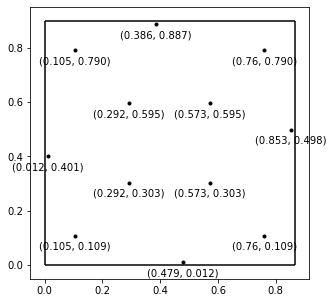

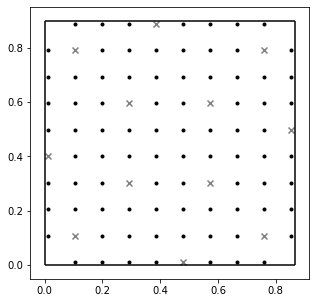

In [9]:
if training_layout == 1:
    tokens = ["x1_y5", "x2_y2", "x2_y9", "x5_y10", "x6_y1", "x9_y2", "x9_y9", "x10_y6"] # Layout 1
elif training_layout == 2:
    tokens = ["x2_y2", "x2_y9", "x4_y4", "x4_y7", "x7_y4", "x7_y7", "x9_y2", "x9_y9"] # Layout 2
elif training_layout == 3:
    tokens = ["x1_y4", "x1_y7", "x4_y1", "x4_y4", "x4_y7", "x4_y10", "x7_y1", "x7_y4", "x7_y7", "x7_y10", "x10_y4", "x10_y7"] # Layout 3
elif training_layout == 4:
    tokens = ["x1_y5", "x2_y2", "x2_y9", "x4_y4", "x4_y7", "x5_y10", "x6_y1", "x7_y4", "x7_y7", "x9_y2", "x9_y9", "x10_y6"] # Arrangement 4
elif training_layout == 5:
    tokens = ["x1_y4", "x2_y2", "x1_y7", "x2_y9", "x4_y1", "x4_y4", "x4_y7", "x4_y10", "x7_y1", "x7_y4", "x7_y7", "x7_y10", "x9_y2", "x9_y9", "x10_y4", "x10_y7"] # Layout 5
elif training_layout == 6:
    tokens = ["x1_y4", "x2_y2", "x1_y7", "x2_y9", "x4_y1", "x5_y7", "x6_y4", "x3_y4", "x3_y7", "x4_y10", "x7_y1", "x8_y4", "x8_y7", "x7_y10", "x9_y2", "x9_y9", "x10_y4", "x10_y7"] # Layout 6

training_group, test_group = create_custom_training_set (srs_path = train_set_path, tokens = tokens, specific = True)

plot_custom_training_set (training_group, test_group)

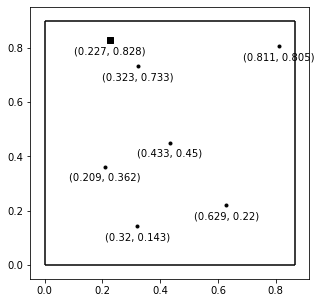

In [10]:
plot_sensor_position(sensor_pos=sensor_position, noise_position=noise_position)

In [11]:
train_X, train_Y = create_labeled_data(srs_path = train_set_path, label_type = model_type, category_group = training_group)
test_X, test_Y = create_labeled_data(srs_path = test_set_path, label_type = model_type, category_group = test_group)
val_X, val_Y = create_labeled_data(srs_path = validation_set_path, label_type = model_type, category_group = test_group)

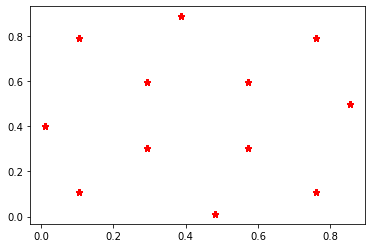

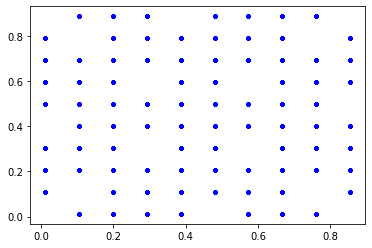

In [12]:
plt.scatter(train_Y[:,0], train_Y[:,1], c='r', marker = '*')
plt.show()

plt.scatter(val_Y[:,0], val_Y[:,1], c='b', marker = '.')
plt.show()

In [15]:
model = CNN_regression(input_shape = (size[1], size[0], channel_sensors))
model.summary()
model.save(model_file_name)

tf.keras.utils.plot_model(model, model_file_name + ".png", show_shapes=True, show_layer_names=True, expand_nested=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 16, 50)         2750      
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 16, 50)         200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 8, 50)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 8, 55)          24805     
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 8, 55)          220       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 4, 55)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 4, 60)          2

2022-04-14 09:29:01.472171: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-14 09:29:01.478284: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-14 09:29:01.847140: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-14 09:29:01.847163: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yarib-IdeaPad-Gaming-3-15ACH6): /proc/driver/nvidia/version does not exist
2022-04-14 09:29:01.847512: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropria

In [ ]:
training_record = train_model(model_file_name = model_file_name, target_mse = target_mse, updates=10, explorations=10, accuracy_threshold = accuracy_threshold, training_record=[])

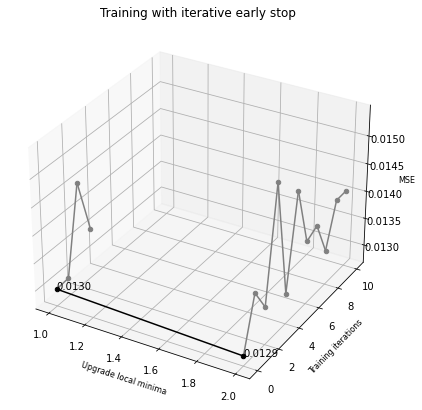

In [176]:
optimization_record = load_optimization_record("optimization_record_" + model_file_name + "_.bin")

plot_optimization_record(training_record=optimization_record, style=1, model_file_name=model_file_name + "_optimization.pdf")


MSE = 0.012231066297566217, mean = 0.09552859837366523, MaxError = 0.4178627017692568
mode = 3464, 0.07; meadian = 3007.0, 0.0862583185120636; mean = 2726.0, 0.09552859837366563.


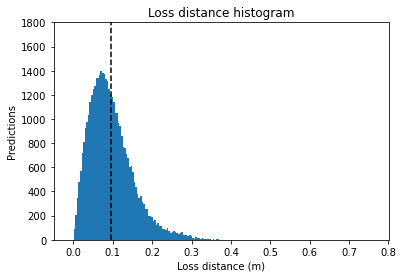

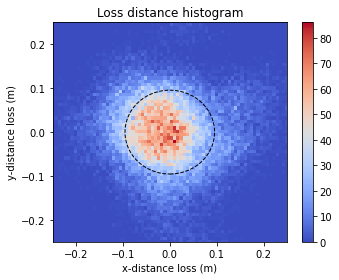

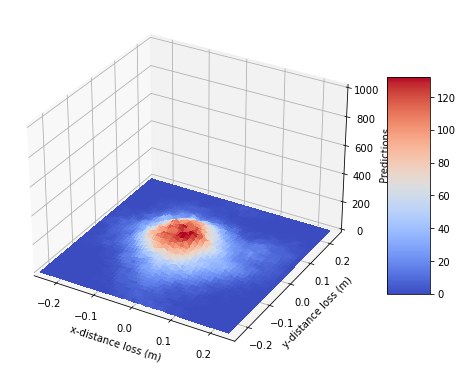

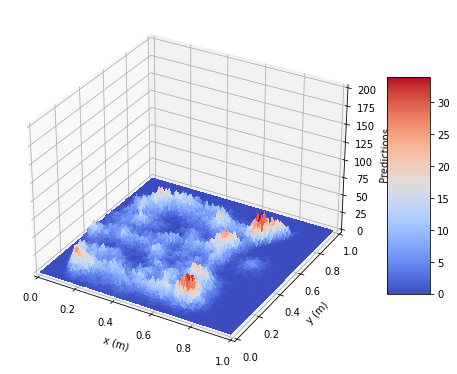

Max MSE = 0.07789251484454962, (0.855,0.795)


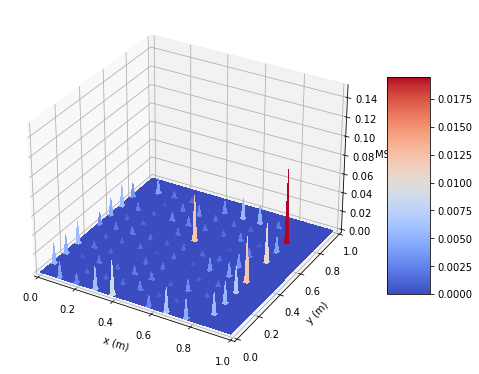

Sensors = 6
MSE = 0.012231066297566217
Ave error = 0.09552859837366523 m
Max error = 0.4178627017692568 m
Accuracy = 0.8517857142857143
Mode = 3464, 0.07


In [19]:
model = load_model(model_file_name)

model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name = "float32")

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

In [ ]:
model.save("F32_" + model_file_name)

2022-04-14 22:44:20.274942: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-14 22:44:20.275793: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-14 22:44:20.627163: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-14 22:44:20.627205: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yarib-IdeaPad-Gaming-3-15ACH6): /proc/driver/nvidia/version does not exist
2022-04-14 22:44:20.627811: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropria

MSE = 0.012231066348257677, mean = 0.09552859842424968, MaxError = 0.4178627017692568
mode = 3464, 0.07; meadian = 3007.0, 0.0862583185120636; mean = 2726.0, 0.09552859842424907.


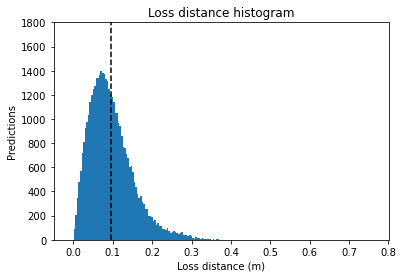

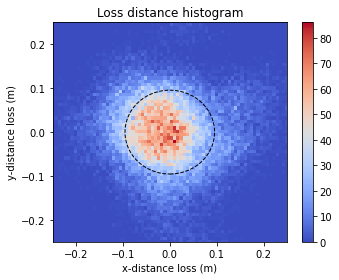

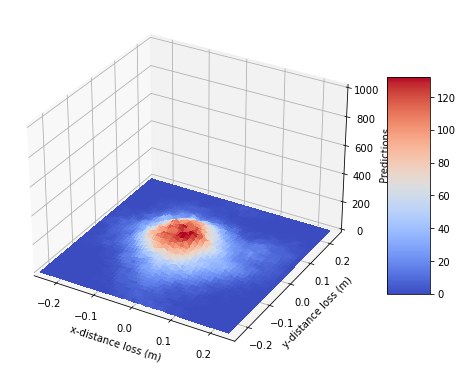

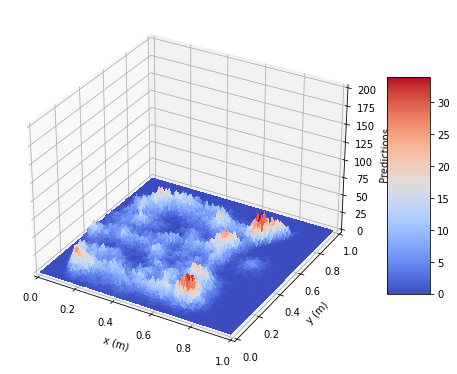

Max MSE = 0.07789251568807404, (0.855,0.795)


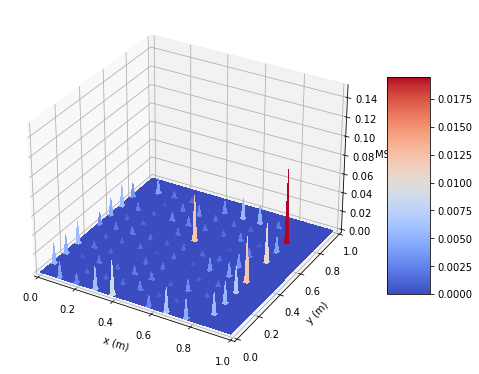

Sensors = 6
MSE = 0.012231066348257677
Ave error = 0.09552859842424968 m
Max error = 0.4178627017692568 m
Accuracy = 0.8517857142857143
Mode = 3464, 0.07


In [17]:
model = load_model("F32_" + model_file_name)

model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name = "float32")

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

In [22]:
convert_to_TF_Lite_float32(model_file_name)

2022-04-14 11:03:29.697891: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp9grzu8pe/assets
model_8x16x6.h5 has been converted to TF Lite (float32).


2022-04-14 11:03:31.058203: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-04-14 11:03:31.058411: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-04-14 11:03:31.058693: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-14 11:03:31.062503: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.005ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-04-14 11:03:31.145839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-04-14 11:03:31.145871: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2022-04-14 11:03:31.176115: I tensorflow/compiler/jit/xla_gpu_device

In [23]:
convert_to_TF_Lite_int8(model_file_name = model_file_name, val_X = val_X)

INFO:tensorflow:Assets written to: /tmp/tmpjp9jspmk/assets


INFO:tensorflow:Assets written to: /tmp/tmpjp9jspmk/assets
2022-04-14 11:03:33.520022: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-04-14 11:03:33.520250: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-04-14 11:03:33.520498: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-14 11:03:33.523215: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.01ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-04-14 11:03:33.592503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-04-14 11:03:33.592550: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


model_8x16x6.h5 has been converted to TF Lite (int8).


mode = 3440, 0.06; meadian = 2972.0, 0.08504757930424389; mean = 2668.0, 0.09519563971437263.


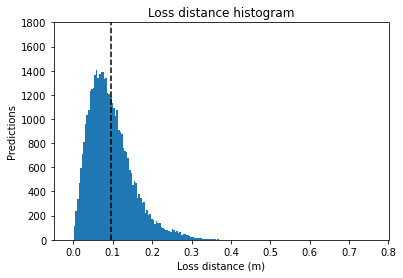

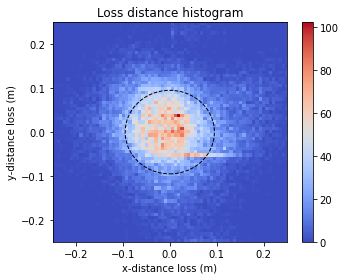

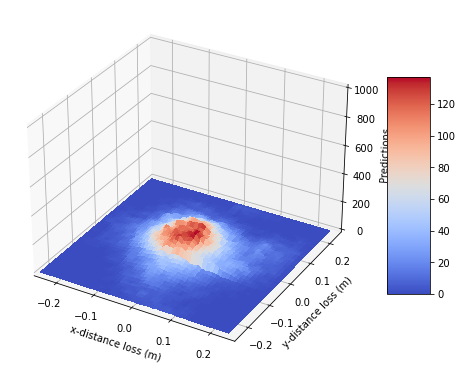

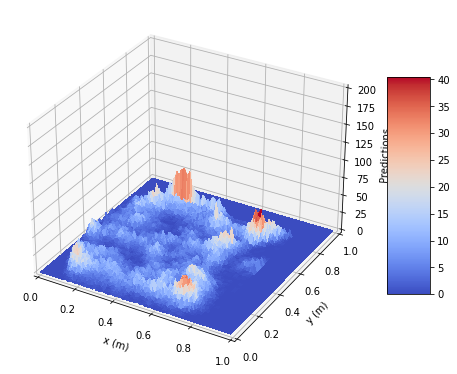

Max MSE = 0.07973273208204978, (0.855,0.795)


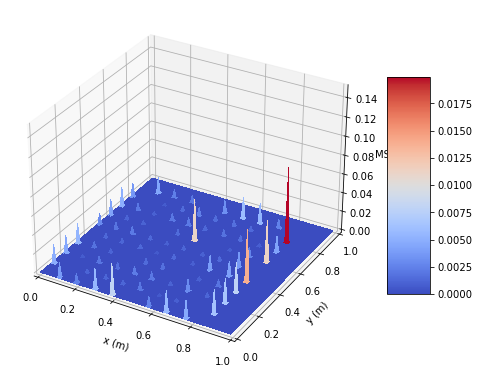

Sensors = 6
MSE = 0.01223500840133204
Ave error = 0.0951956397143725 m
Max error = 0.4254305297817202 m
Accuracy = 0.8505
Mode = 3440, 0.06


In [24]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = model_file_name + "_i8" + '.tflite')
interpreter.allocate_tensors()

model_evaluation = evaluate_regression_TF_Lite(interpreter = interpreter, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name="int8")

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

_______ Post-training custom floating-point quantization _______
Loading F32_model_8x16x6.h5
MSE = 0.012231066348257677, mean = 0.09552859842424968, MaxError = 0.4178627017692568
mode = 3464, 0.07; meadian = 3007.0, 0.0862583185120636; mean = 2726.0, 0.09552859842424907.


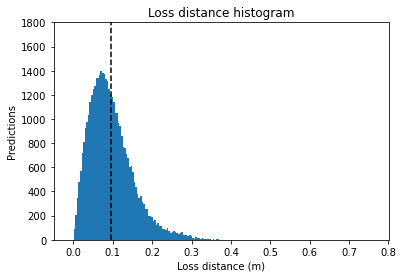

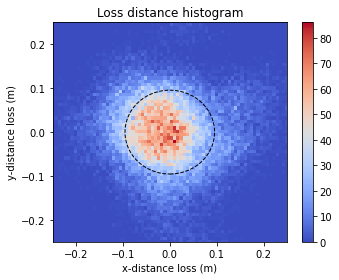

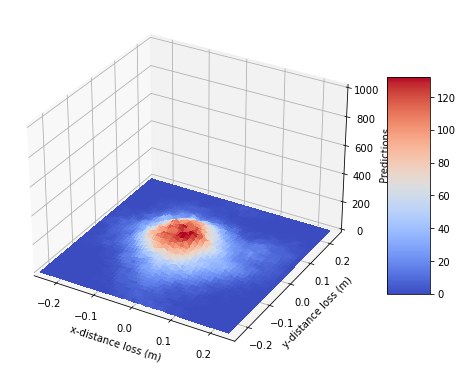

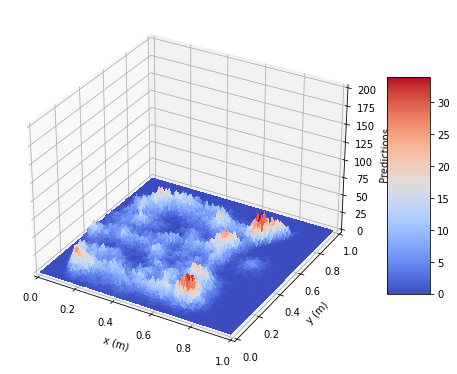

Max MSE = 0.07789251568807404, (0.855,0.795)


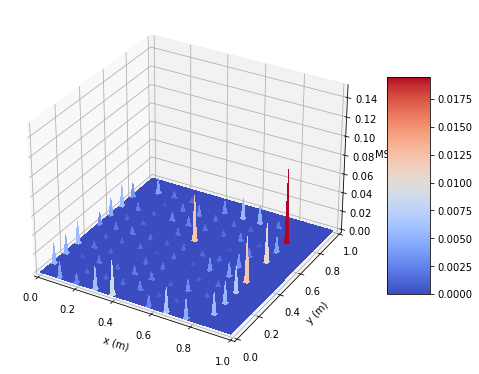

Initial metrics:
MSE = 0.012231066348257677
Ave error = 0.09552859842424968 m
Max error = 0.4178627017692568 m
Accuracy = 0.8517857142857143
Mode = 3464, 0.07


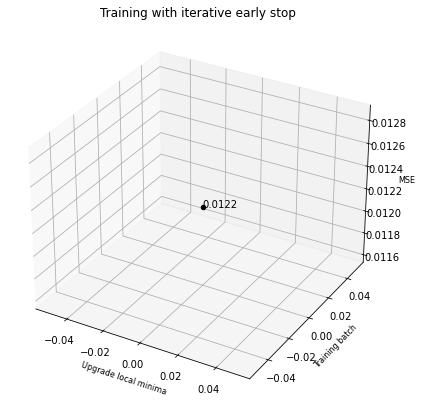

MSE = 0.012033213328254409, mean = 0.09453844805998605, MaxError = 0.414296378402463
mode = 3521, 0.06; meadian = 2979.0, 0.08500340758197493; mean = 2979.0, 0.0945384480599856.


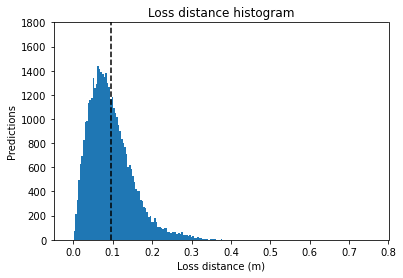

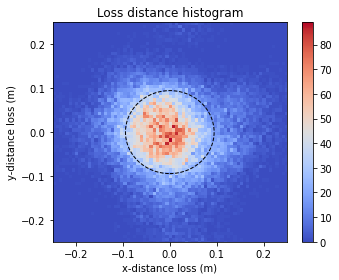

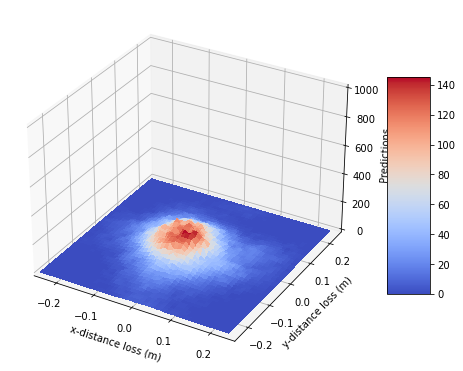

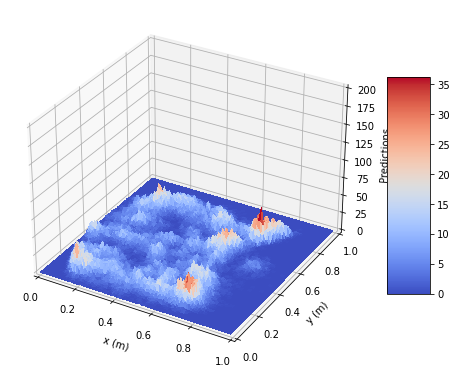

Max MSE = 0.0778851580902172, (0.855,0.795)


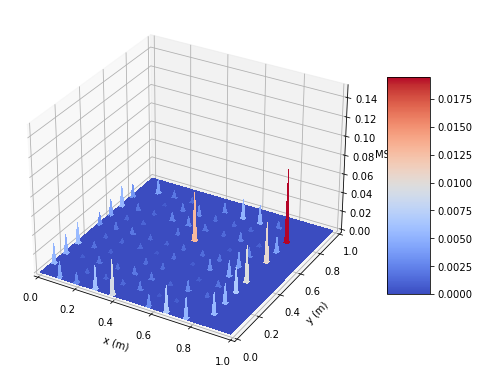

Custom floating-point quantization. Exponent = 4, Mantissa = 3.
Post-training quantization metrics:
MSE = 0.012033213328254409
Ave error = 0.09453844805998605 m
Max error = 0.414296378402463 m
Accuracy = 0.8551904761904762
Mode = 3521, 0.06


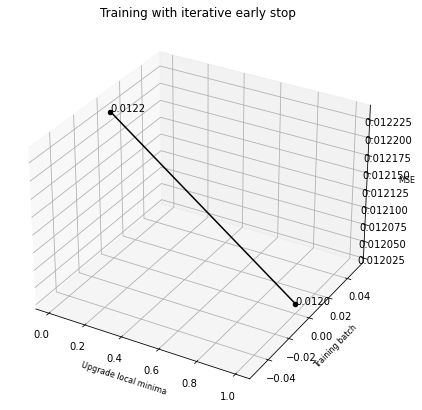

_______ TUNING _______
Start tuning...
Tuning schedule [Regularization/2]. Tuning on batch = False, batch size = 10
Tuning for MSE
   6/2400 [..............................] - ETA: 6:23 - loss: 0.0057 - mean_squared_error: 0.0057WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0050s vs `on_train_batch_end` time: 0.1561s). Check your callbacks.


2400/2400 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

2022-04-15 09:05:20.069252: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 516096000 exceeds 10% of free system memory.


2400/2400 [==============================] - 419s 174ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
MSE = 0.012187841392111282, mean = 0.09539579648192013, MaxError = 0.4304832224380237
mode = 3349, 0.08; meadian = 3125.0, 0.08745863949034802; mean = 2890.0, 0.0953957964819208.
 Regression MSE = 0.012187841392111282
MSE = 0.012231066348257677, mean = 0.09552859842424968, MaxError = 0.4178627017692568
mode = 3464, 0.07; meadian = 3007.0, 0.0862583185120636; mean = 2726.0, 0.09552859842424907.
Tuning schedule [Capture/2]. Tuning on batch = True, batch size = 10
Tuning for MSE
   1/2400 [..............................] - ETA: 11:38 - loss: 0.0026 - mean_squared_error: 0.0026MSE = 0.017093773697687765, mean = 0.11331390574763381, MaxError = 0.4433793427143448
mode = 2758, 0.07; meadian = 2601.0, 0.1032492899709352; mean = 2391.0, 0.1133139057476335.
   2/2400 [..............................] - ETA: 2:57:07 - loss: 0.0024 - mean_squar

   7/2400 [..............................] - ETA: 2:52:12 - loss: 0.0049 - mean_squared_error: 0.0049MSE = 0.019184594482264124, mean = 0.12488708627145291, MaxError = 0.4034369794264507
mode = 2731, 0.11; meadian = 2678.0, 0.12003586979334566; mean = 2678.0, 0.12488708627145267.
   8/2400 [..............................] - ETA: 2:51:17 - loss: 0.0054 - mean_squared_error: 0.0054MSE = 0.013627408938904146, mean = 0.10123160532696102, MaxError = 0.36785266976816844
mode = 3233, 0.07; meadian = 2882.0, 0.09100306934021196; mean = 2544.0, 0.10123160532696124.
   9/2400 [..............................] - ETA: 2:52:05 - loss: 0.0052 - mean_squared_error: 0.0052MSE = 0.01584131025333396, mean = 0.10918325727958086, MaxError = 0.4017177640210305
mode = 3049, 0.07; meadian = 2650.0, 0.09814212961599691; mean = 2461.0, 0.10918325727958075.
  10/2400 [..............................] - ETA: 2:52:16 - loss: 0.0051 - mean_squared_error: 0.0051MSE = 0.012499473933381751, mean = 0.09894979180945196, 

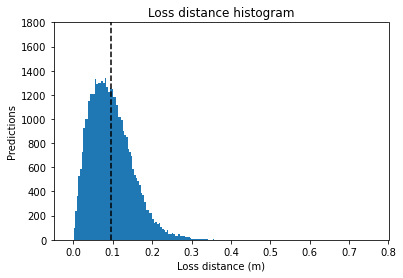

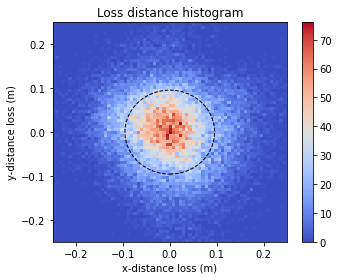

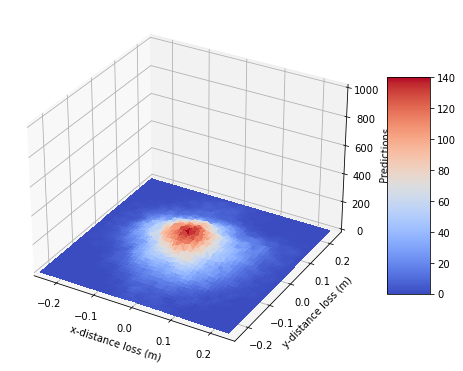

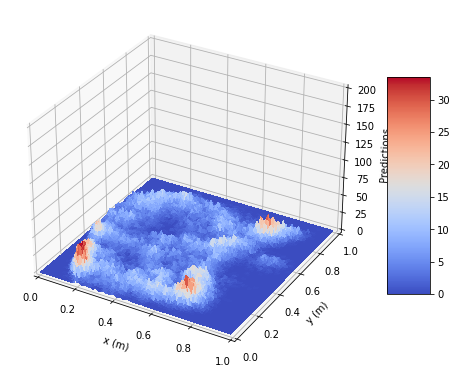

Max MSE = 0.05563088598014786, (0.475,0.595)


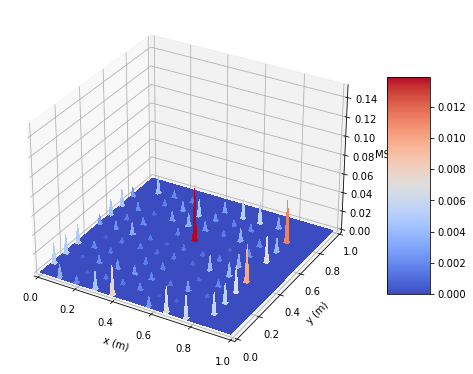

MSE = 0.011987353518925993
Ave error = 0.09560417269083904 m
Max error = 0.4035576611813699 m
Accuracy = 0.85
Mode = 3139, 0.07


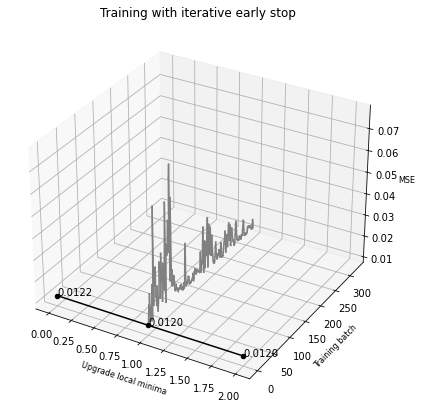

 324/2400 [===>..........................] - ETA: 2:32:53 - loss: 0.0065 - mean_squared_error: 0.0065MSE = 0.012831834563039834, mean = 0.09938619444125446, MaxError = 0.3945295346956847
mode = 3104, 0.07; meadian = 2977.0, 0.0926302148234689; mean = 2813.0, 0.09938619444125515.
 325/2400 [===>..........................] - ETA: 2:32:49 - loss: 0.0064 - mean_squared_error: 0.0064MSE = 0.015235918327349704, mean = 0.10948774748934743, MaxError = 0.381124796014814
mode = 2938, 0.08; meadian = 2782.0, 0.10266887351420395; mean = 2667.0, 0.10948774748934682.
 326/2400 [===>..........................] - ETA: 2:32:44 - loss: 0.0064 - mean_squared_error: 0.0064MSE = 0.019375828671717117, mean = 0.12532802453880548, MaxError = 0.4030681207441318
mode = 2907, 0.1; meadian = 2744.0, 0.11851812398074682; mean = 2477.0, 0.12532802453880384.
 327/2400 [===>..........................] - ETA: 2:32:39 - loss: 0.0064 - mean_squared_error: 0.0064MSE = 0.024963537498674068, mean = 0.1445536769405585, MaxE

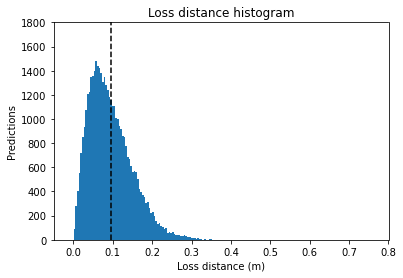

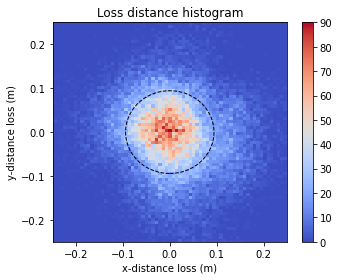

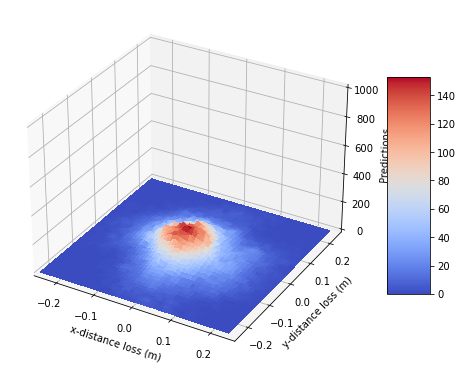

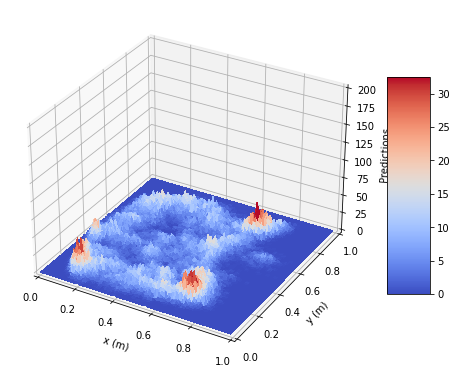

Max MSE = 0.05579450586360078, (0.475,0.595)


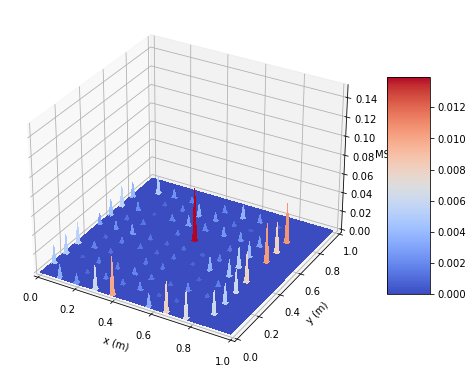

MSE = 0.011923602291532732
Ave error = 0.09429642473707289 m
Max error = 0.40767535758703904 m
Accuracy = 0.8420238095238095
Mode = 3349, 0.06


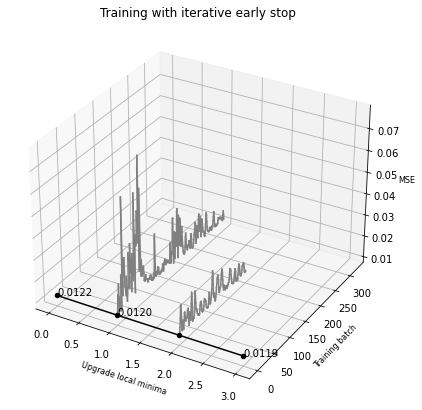

 526/2400 [=====>........................] - ETA: 2:18:26 - loss: 0.0057 - mean_squared_error: 0.0057MSE = 0.011732030882817194, mean = 0.09443677753371031, MaxError = 0.41504423541104
mode = 3314, 0.06; meadian = 2981.0, 0.08651788837542304; mean = 2981.0, 0.09443677753371092.
 Saveing model ...
 Regression MSE = 0.011732030882817194
MSE = 0.011732030882817194, mean = 0.09443677753371031, MaxError = 0.41504423541104
mode = 3314, 0.06; meadian = 2981.0, 0.08651788837542304; mean = 2981.0, 0.09443677753371092.


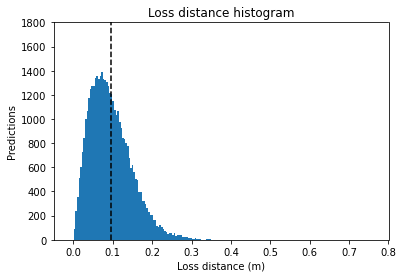

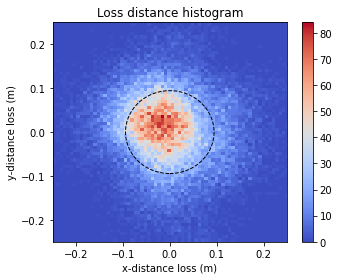

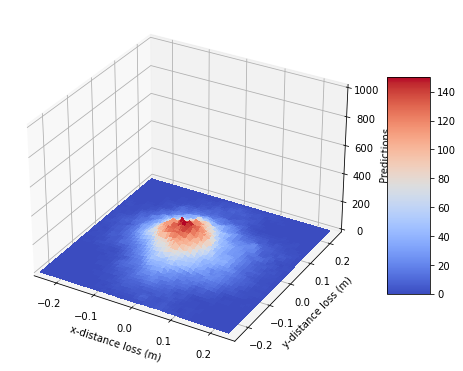

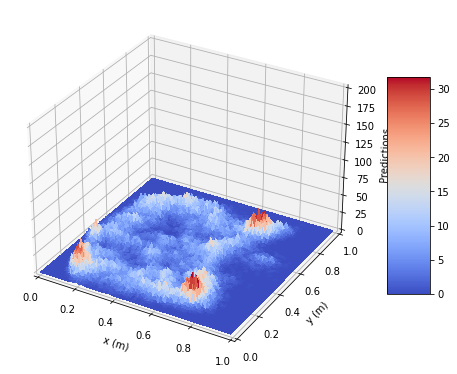

Max MSE = 0.05180998269700481, (0.475,0.595)


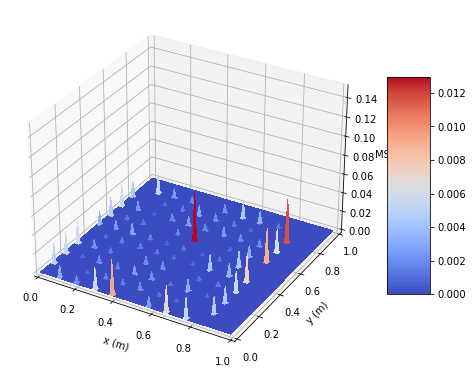

MSE = 0.011732030882817194
Ave error = 0.09443677753371031 m
Max error = 0.41504423541104 m
Accuracy = 0.8519523809523809
Mode = 3314, 0.06


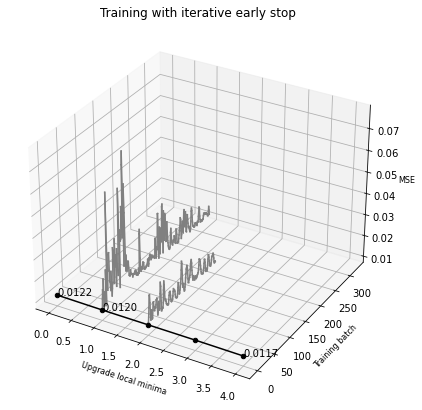

 527/2400 [=====>........................] - ETA: 2:18:55 - loss: 0.0057 - mean_squared_error: 0.0057MSE = 0.011885353387003476, mean = 0.09538815818485206, MaxError = 0.41125606018849475
mode = 3321, 0.07; meadian = 3111.0, 0.08794079020182619; mean = 2775.0, 0.09538815818485126.
 528/2400 [=====>........................] - ETA: 2:18:50 - loss: 0.0057 - mean_squared_error: 0.0057MSE = 0.011941348544841213, mean = 0.09541694883921958, MaxError = 0.4036594327922068
mode = 3385, 0.06; meadian = 3017.0, 0.08750944092627264; mean = 2772.0, 0.09541694883921986.
 529/2400 [=====>........................] - ETA: 2:18:45 - loss: 0.0057 - mean_squared_error: 0.0057MSE = 0.01218990794012673, mean = 0.0961326865834383, MaxError = 0.39234341087226393
mode = 3468, 0.06; meadian = 2963.0, 0.08729704513179477; mean = 2715.0, 0.09613268658343745.
 530/2400 [=====>........................] - ETA: 2:18:40 - loss: 0.0057 - mean_squared_error: 0.0057MSE = 0.012590624704650414, mean = 0.09706285968633979, 

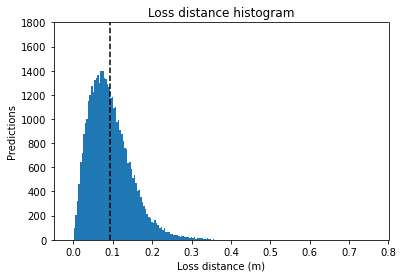

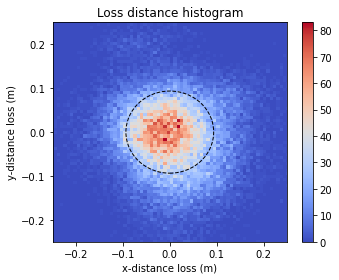

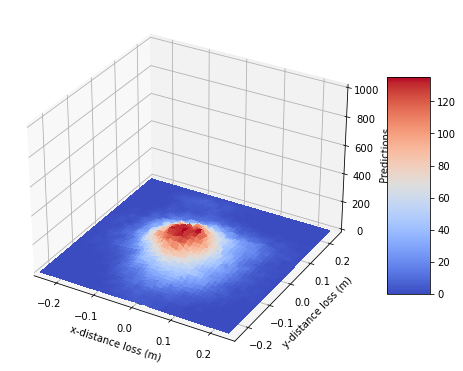

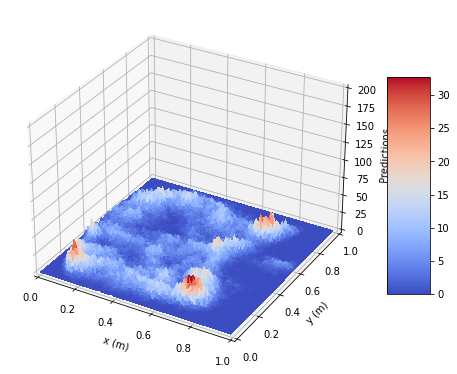

Max MSE = 0.0676762975224025, (0.475,0.595)


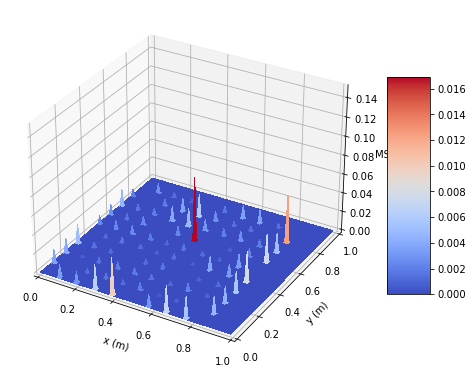

MSE = 0.011662666749661252
Ave error = 0.09358344260955352 m
Max error = 0.41827705020529593 m
Accuracy = 0.8595238095238096
Mode = 3422, 0.07


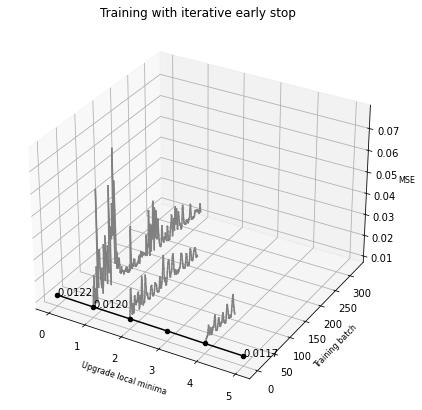

 618/2400 [======>.......................] - ETA: 2:12:24 - loss: 0.0054 - mean_squared_error: 0.0054MSE = 0.011707900583146916, mean = 0.09413524690563983, MaxError = 0.42676932311373084
mode = 3443, 0.06; meadian = 3053.0, 0.08633726207751655; mean = 3053.0, 0.09413524690563917.
 619/2400 [======>.......................] - ETA: 2:12:20 - loss: 0.0054 - mean_squared_error: 0.0054MSE = 0.01140608014579584, mean = 0.09306843589256404, MaxError = 0.42743976419973573
mode = 3383, 0.07; meadian = 3146.0, 0.08558058064040351; mean = 3146.0, 0.09306843589256378.
 Saveing model ...
 Regression MSE = 0.01140608014579584
MSE = 0.01140608014579584, mean = 0.09306843589256404, MaxError = 0.42743976419973573
mode = 3383, 0.07; meadian = 3146.0, 0.08558058064040351; mean = 3146.0, 0.09306843589256378.


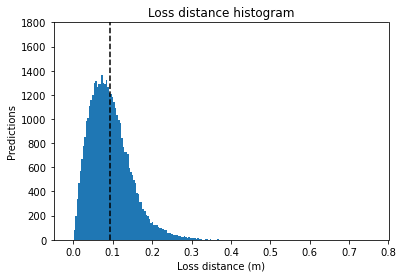

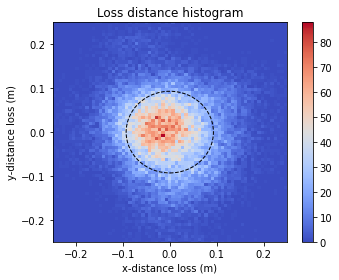

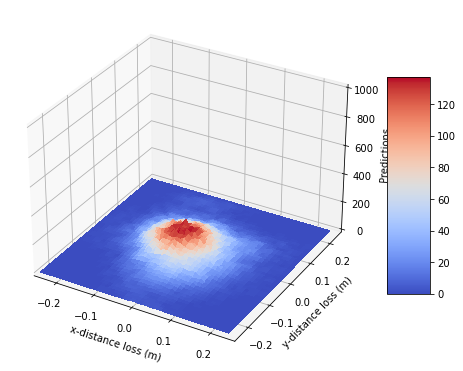

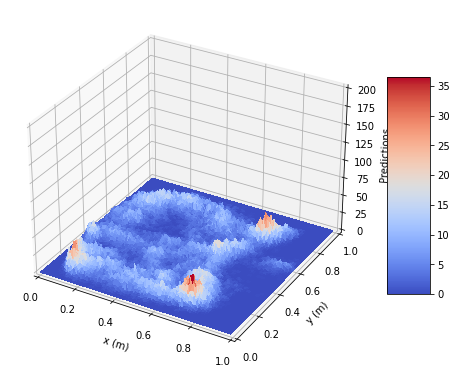

Max MSE = 0.0580154214858702, (0.475,0.595)


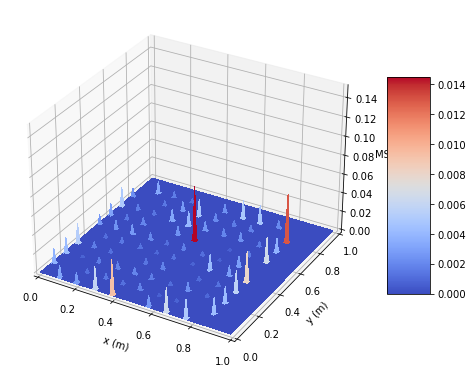

MSE = 0.01140608014579584
Ave error = 0.09306843589256404 m
Max error = 0.42743976419973573 m
Accuracy = 0.866904761904762
Mode = 3383, 0.07


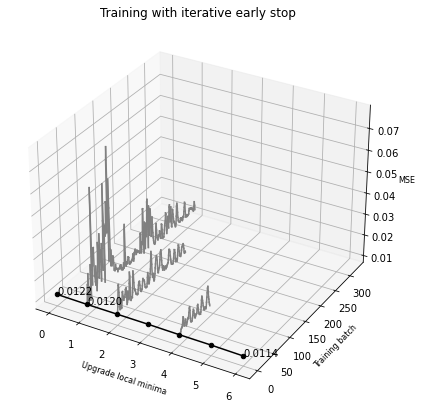

 620/2400 [======>.......................] - ETA: 2:12:44 - loss: 0.0054 - mean_squared_error: 0.0054MSE = 0.011458593713374338, mean = 0.0933181965335703, MaxError = 0.4242421412323837
mode = 3363, 0.07; meadian = 3140.0, 0.08587077936804136; mean = 3140.0, 0.09331819653357001.
 621/2400 [======>.......................] - ETA: 2:12:39 - loss: 0.0054 - mean_squared_error: 0.0054MSE = 0.011947525487830742, mean = 0.09520619864436866, MaxError = 0.4174701005245492
mode = 3330, 0.08; meadian = 2987.0, 0.08721170891864866; mean = 2660.0, 0.09520619864436806.
 622/2400 [======>.......................] - ETA: 2:12:35 - loss: 0.0054 - mean_squared_error: 0.0054MSE = 0.013184878957754541, mean = 0.10011620399052379, MaxError = 0.4030941539234309
mode = 3205, 0.07; meadian = 3042.0, 0.09161376307716973; mean = 2737.0, 0.10011620399052339.
 623/2400 [======>.......................] - ETA: 2:12:30 - loss: 0.0054 - mean_squared_error: 0.0054MSE = 0.015016864551119755, mean = 0.10732766037802435, M

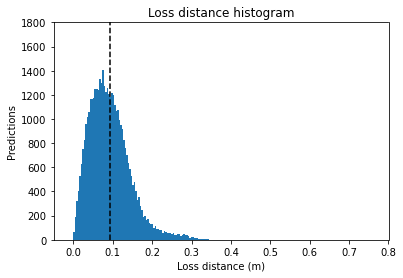

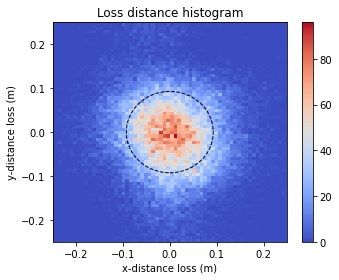

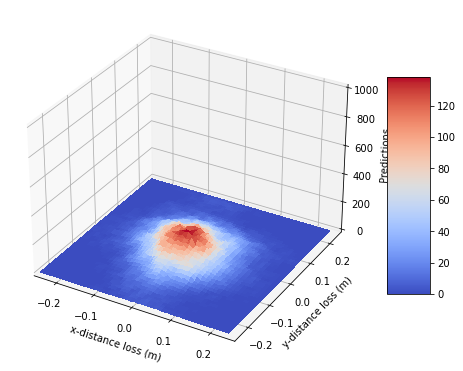

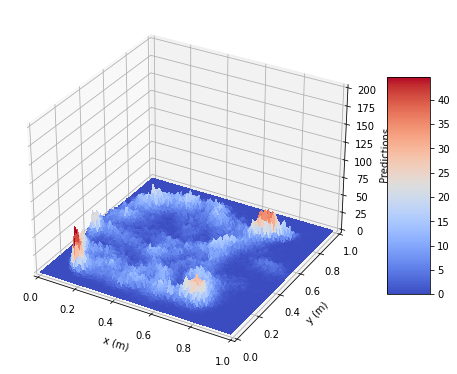

Max MSE = 0.06532690924450509, (0.855,0.795)


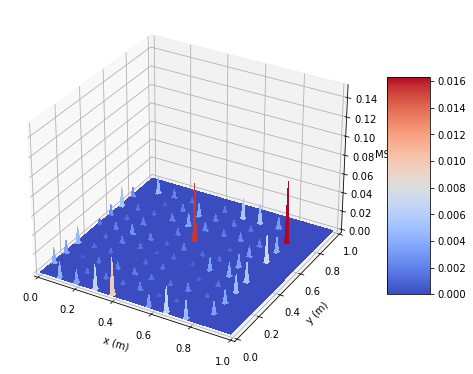

MSE = 0.011372325663473223
Ave error = 0.09270866024428177 m
Max error = 0.4969626183274009 m
Accuracy = 0.877
Mode = 3509, 0.07


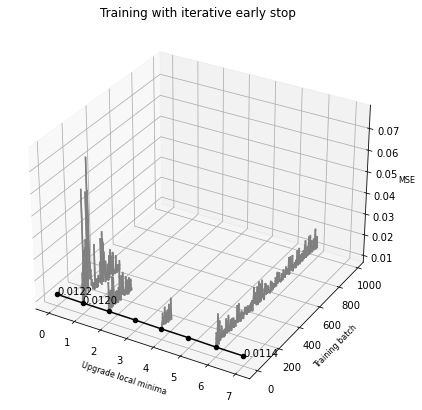

1608/2400 [===================>..........] - ETA: 58:35 - loss: 0.0041 - mean_squared_error: 0.0041MSE = 0.011612765513225492, mean = 0.09386181947026086, MaxError = 0.49936090933792
mode = 3435, 0.07; meadian = 3229.0, 0.08691835229598574; mean = 3229.0, 0.09386181947026052.
1609/2400 [===================>..........] - ETA: 58:30 - loss: 0.0041 - mean_squared_error: 0.0041MSE = 0.011788748240428581, mean = 0.09477411966973219, MaxError = 0.4986133142993845
mode = 3448, 0.08; meadian = 3263.0, 0.08798645851284506; mean = 3263.0, 0.0947741196697321.
1610/2400 [===================>..........] - ETA: 58:26 - loss: 0.0041 - mean_squared_error: 0.0041MSE = 0.01182673859106763, mean = 0.09496507673903222, MaxError = 0.49072963943978953
mode = 3443, 0.08; meadian = 3283.0, 0.08820859153787076; mean = 3283.0, 0.09496507673903137.
1611/2400 [===================>..........] - ETA: 58:21 - loss: 0.0041 - mean_squared_error: 0.0041MSE = 0.011572855689341277, mean = 0.09378392384080014, MaxError = 

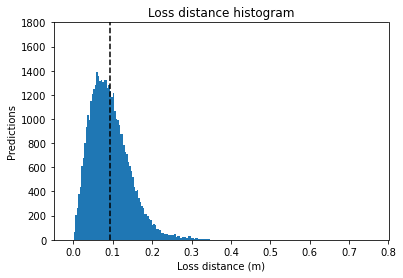

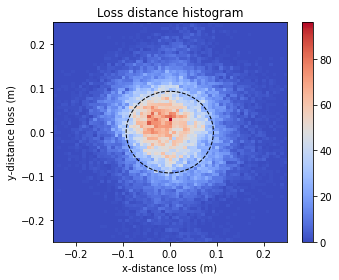

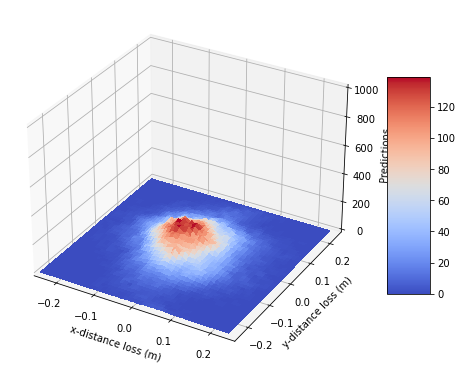

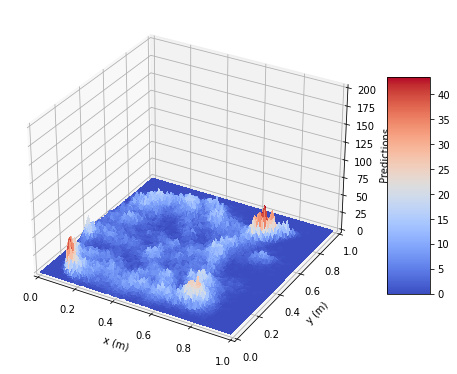

Max MSE = 0.06367585618221804, (0.475,0.595)


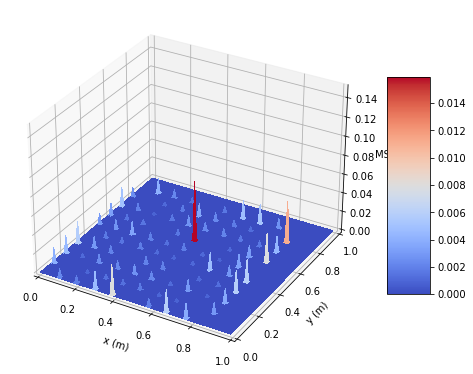

MSE = 0.011270106221352959
Ave error = 0.09301642447775481 m
Max error = 0.4581214660578719 m
Accuracy = 0.873
Mode = 3514, 0.06


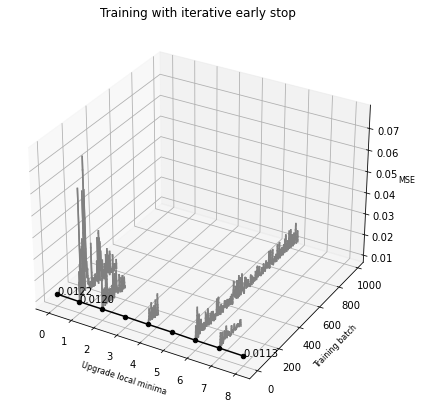

1808/2400 [=====================>........] - ETA: 43:53 - loss: 0.0039 - mean_squared_error: 0.0039MSE = 0.011290528967899702, mean = 0.0930183924713274, MaxError = 0.4627485800338591
mode = 3518, 0.07; meadian = 3266.0, 0.08573772753415251; mean = 3266.0, 0.09301839247132716.
1809/2400 [=====================>........] - ETA: 43:49 - loss: 0.0039 - mean_squared_error: 0.0039MSE = 0.01134464715940346, mean = 0.09299325246705221, MaxError = 0.46003308580572944
mode = 3526, 0.06; meadian = 3219.0, 0.08536441888119317; mean = 3219.0, 0.09299325246705178.
1810/2400 [=====================>........] - ETA: 43:44 - loss: 0.0039 - mean_squared_error: 0.0039MSE = 0.011383094965288918, mean = 0.09302537701882857, MaxError = 0.45882170927762855
mode = 3512, 0.06; meadian = 3177.0, 0.08518047116956551; mean = 3177.0, 0.09302537701882906.
1811/2400 [=====================>........] - ETA: 43:40 - loss: 0.0039 - mean_squared_error: 0.0039MSE = 0.011553443399664522, mean = 0.09325733743926931, MaxError

2022-04-15 12:04:27.603022: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 516096000 exceeds 10% of free system memory.


2400/2400 [==============================] - 10741s 4s/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
MSE = 0.01693827695349073, mean = 0.11593327674198622, MaxError = 0.4888159429248915
mode = 2995, 0.1; meadian = 2897.0, 0.10896356440094668; mean = 2624.0, 0.1159332767419874.
 Regression MSE = 0.01693827695349073
MSE = 0.011270106221352959, mean = 0.09301642447775481, MaxError = 0.4581214660578719
mode = 3514, 0.06; meadian = 3211.0, 0.0856977744055123; mean = 3211.0, 0.09301642447775413.
Final quantization metrics:
MSE = 0.011270106221352959
Ave error = 0.09301642447775481 m
Max error = 0.4581214660578719 m
Accuracy = 0.873
Mode = 3514, 0.06


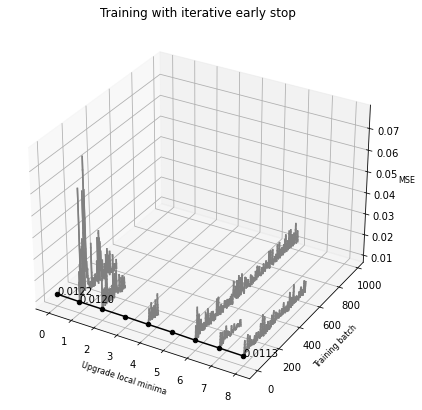

End tuning.


In [29]:
quantize_enable = True

tune_metric = 1 # 1="MSE", 2="AVE ERROR", 3="FIXED MODE", 4="LOWER MODE", 5="ACCURACY"
max_mode = 3450 #3250
lowest_mse = 0.001
lowest_mean = 0.001

tuning_schedule = { "Regularization" : (False, 10 ),
                    "Capture"        : (True,  10 )}

plot_histogram = True
optimization_record = []
tuning_parameters = {
    "base_model_file_name" : "F32_" + model_file_name,
    "model_file_name" : format_name + "_" + model_file_name,
    "tune" : tune_metric,
    "max_mode" : max_mode,
    "lowest_mse" : lowest_mse,
    "lowest_mean" : lowest_mean,
    "exponent_bit_width" : exponent_bit_width,
    "mantissa_bit_width" : mantissa_bit_width,
    "train_set_x" : train_X,
    "train_set_y" : train_Y,
    "test_set_x" : test_X,
    "test_set_y" : test_Y,
    "val_set_x" : val_X,
    "val_set_y" : val_Y,
    "accuracy_threshold" : accuracy_threshold,
    "tuning_epochs" : 1,
    "tuning_schedule" : tuning_schedule,
    "quantize_enable" : quantize_enable,
    "plot_histogram" : plot_histogram,
    "optimization_record" : optimization_record
    }

custom_floating_point_tuning(tuning_parameters)

optimization_record_E4M3_model_8x16x6.h5_.bin


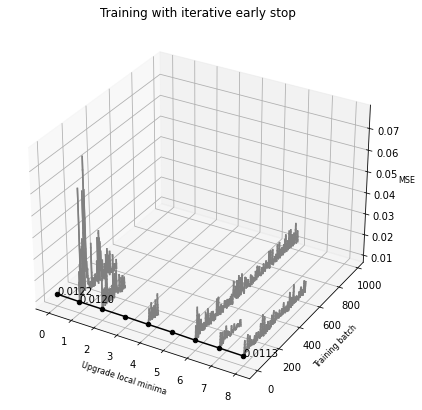

In [30]:
print("optimization_record_" + format_name + "_" + model_file_name + "_.bin")
plot_optimization_record(training_record=load_optimization_record("optimization_record_" + format_name + "_" + model_file_name + "_.bin"), \
                         style = 2,\
                         model_file_name="optimization_record_" + format_name + "_" + model_file_name)
#plot_optimization_record(optimization_record)
#save_optimization_record(training_record=optimization_record, file="optimization_record_" + format_name + "_" + model_file_name + "_.bin")

MSE = 0.012033213328254409, mean = 0.09453844805998605, MaxError = 0.414296378402463
mode = 3521, 0.06; meadian = 2979.0, 0.08500340758197493; mean = 2979.0, 0.0945384480599856.


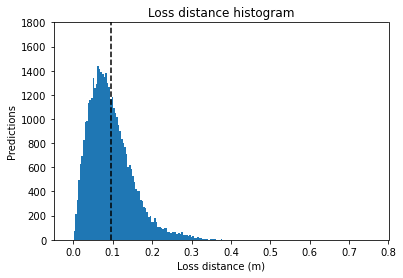

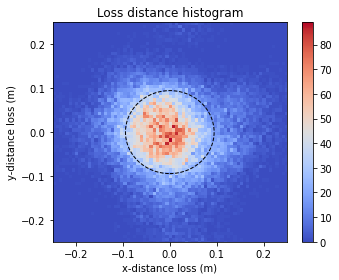

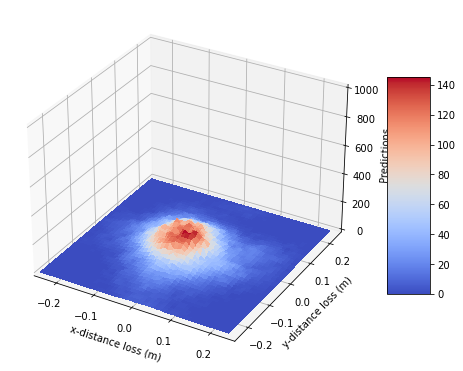

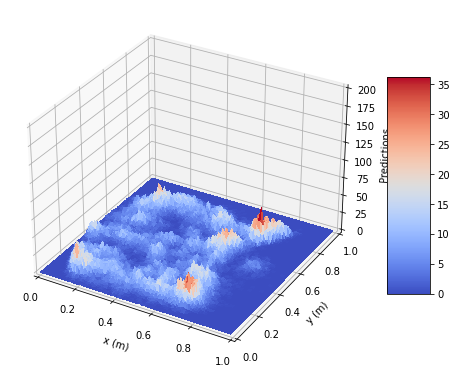

Max MSE = 0.0778851580902172, (0.855,0.795)


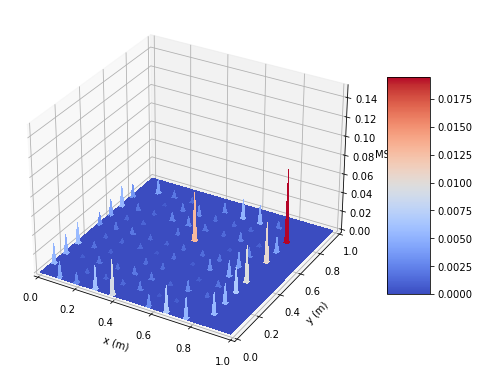

Sensors = 6
MSE = 0.012033213328254409
Ave error = 0.09453844805998605 m
Max error = 0.414296378402463 m
Accuracy = 0.8551904761904762
Mode = 3521, 0.06


In [31]:
model = load_model("F32_" + model_file_name)

quantize_model(model, exponent_bit_width, mantissa_bit_width)

model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name = format_name + "_woq_" + model_file_name)

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

MSE = 0.011270106221352959, mean = 0.09301642447775481, MaxError = 0.4581214660578719
mode = 3514, 0.06; meadian = 3211.0, 0.0856977744055123; mean = 3211.0, 0.09301642447775413.


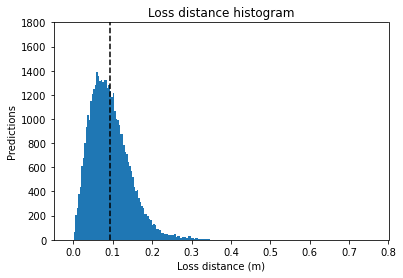

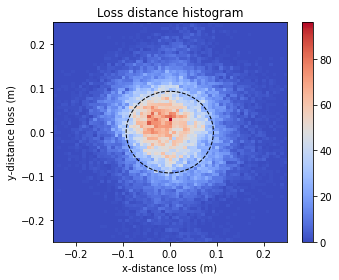

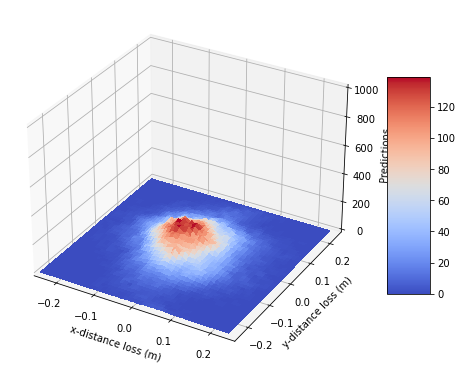

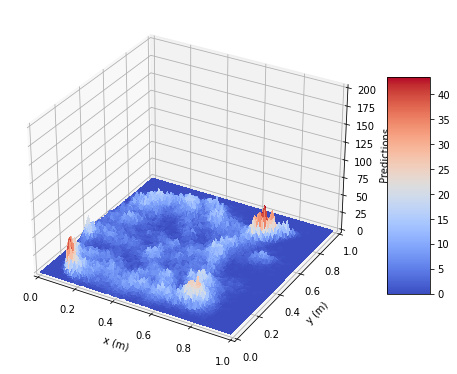

Max MSE = 0.06367585618221804, (0.475,0.595)


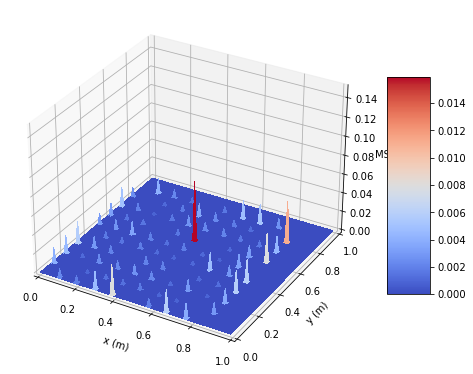

Sensors = 6
MSE = 0.011270106221352959
Ave error = 0.09301642447775481 m
Max error = 0.4581214660578719 m
Accuracy = 0.873
Mode = 3514, 0.06


In [32]:
model = load_model(format_name + "_" + model_file_name)

#print_model (model)

model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name=format_name)

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

In [33]:
convert_to_TF_Lite_int8(model_file_name = format_name + "_" + model_file_name, val_X = val_X)

INFO:tensorflow:Assets written to: /tmp/tmpyk52an7r/assets


INFO:tensorflow:Assets written to: /tmp/tmpyk52an7r/assets
2022-04-15 17:56:33.124715: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-04-15 17:56:33.125587: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-04-15 17:56:33.127264: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-15 17:56:33.139764: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.015ms.
  function_optimizer: function_optimizer did nothing. time = 0.002ms.



E4M3_model_8x16x6.h5 has been converted to TF Lite (int8).


2022-04-15 17:56:33.236571: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-04-15 17:56:33.236630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


mode = 3528, 0.06; meadian = 3141.0, 0.0868921776447184; mean = 3141.0, 0.09441726258130498.


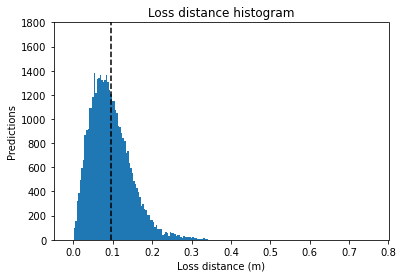

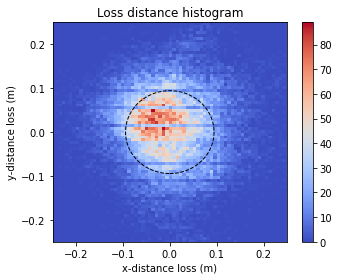

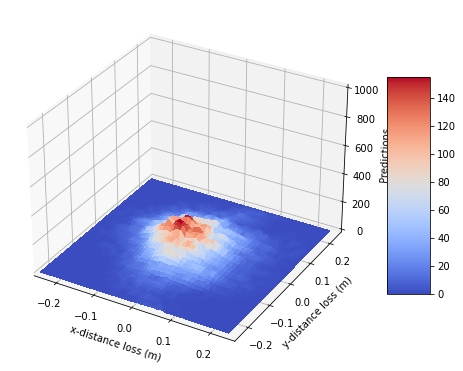

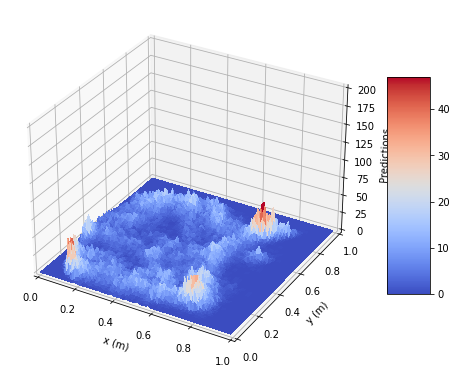

Max MSE = 0.062339035996296206, (0.475,0.595)


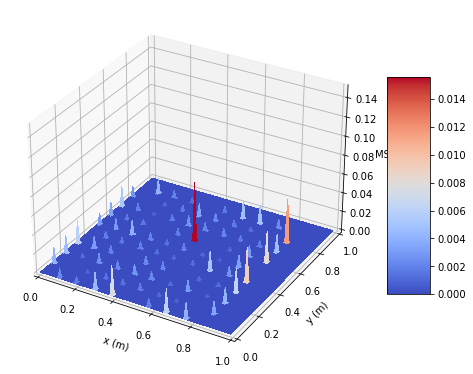

Sensors = 6
MSE = 0.011613962303699703
Ave error = 0.0944172625813053 m
Max error = 0.4336062511457282 m
Accuracy = 0.8647857142857143
Mode = 3528, 0.06


In [34]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = format_name + "_" + model_file_name + "_i8" + '.tflite')
interpreter.allocate_tensors()

model_evaluation = evaluate_regression_TF_Lite(interpreter = interpreter, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name=format_name+"_int8_")

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

Input sample = validation_set/P_x5_y9/sample_2350.npy, model prediction = [[0.36221498 0.83567345]]
(0.386, 0.7904)


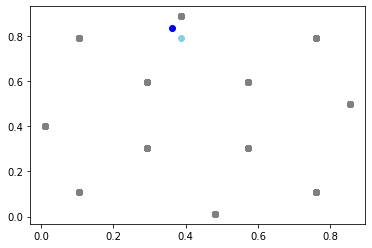

In [35]:
category_name = "P_x5_y9"

file = validation_set_path + "/" + category_name + "/sample_2350.npy"

sample = np.load(file)
sample = sample.astype('float32') / 255.0
sample = np.expand_dims(sample, axis=0)

model = load_model(format_name +"_"+ model_file_name)

model_output = model.predict(sample)

if model_type == "regression":
    print("Input sample = {}, model prediction = {}".format(file, model_output))
else:
    print("Input sample = {}, model prediction = {}".format(file, get_category(model_output)))

tensor = np.zeros((1, 2))

x_i = int(category_name.split("_")[1].split("x")[1]) - 1
y_i = int(category_name.split("_")[2].split("y")[1]) - 1

x_pos = 0.0935 * x_i + 0.012
y_pos = 0.0973 * y_i + 0.012
tensor[0,:] = [x_pos, y_pos]

print("({}, {})".format(x_pos, y_pos))

plt.scatter(train_Y[:,0], train_Y[:,1], c='gray')
plt.scatter(tensor[:,0], tensor[:,1], c='skyblue')
plt.scatter(model_output[:,0], model_output[:,1], c='blue')
plt.show()

Grid (sample = 280, channels = 3)


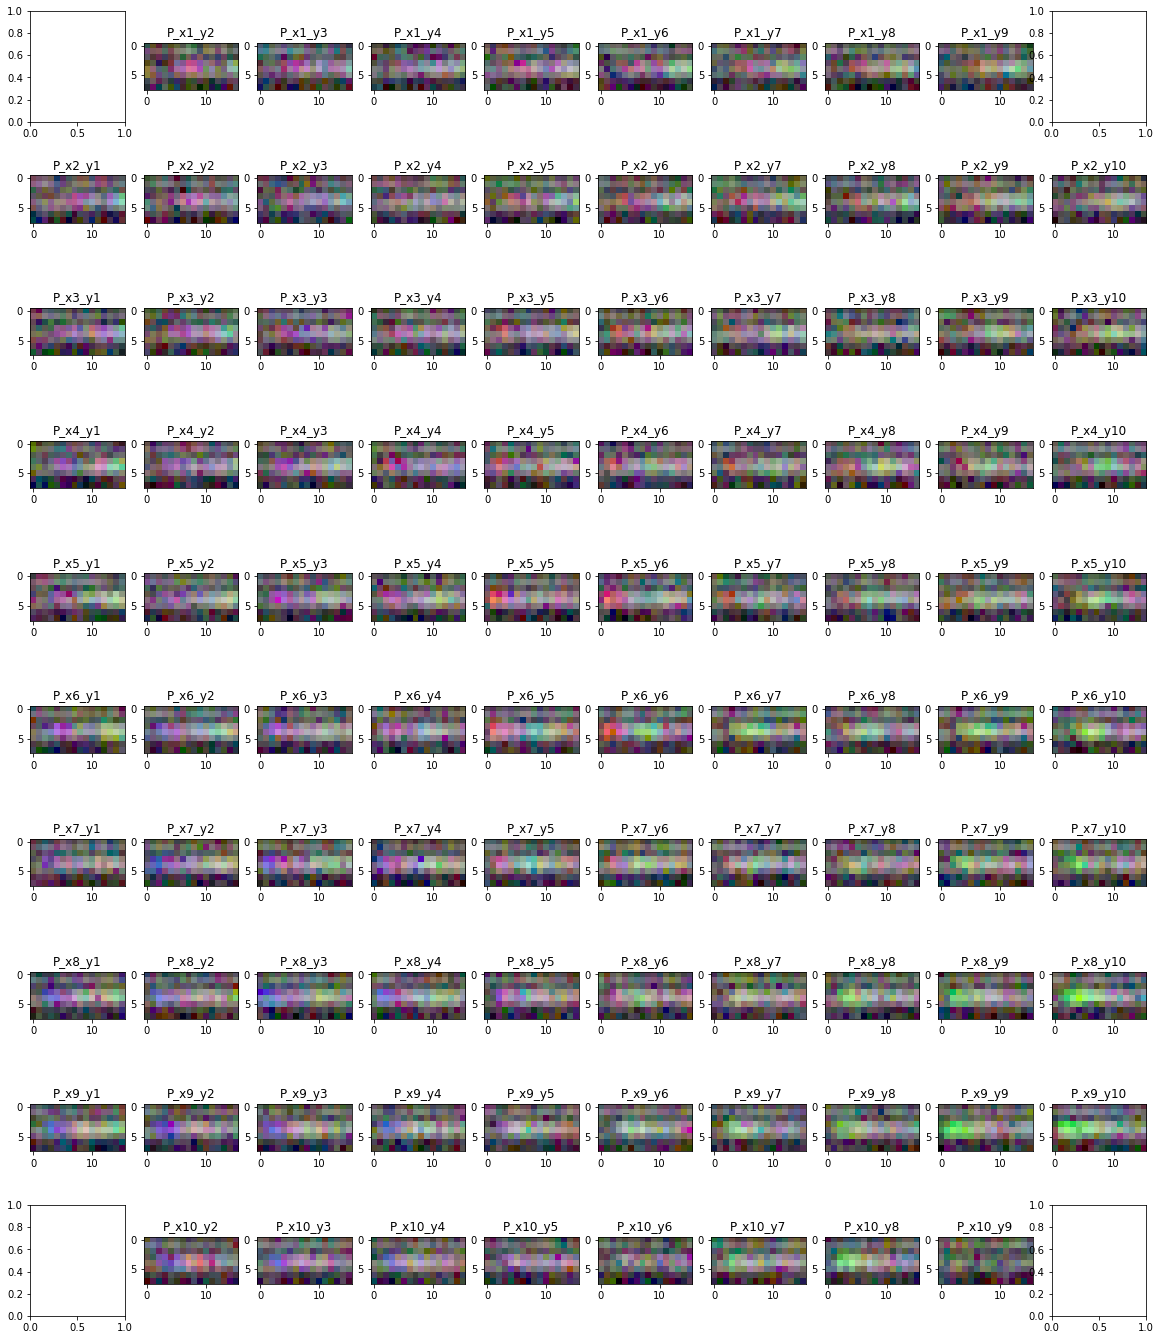

In [ ]:
show_grid(sample = 280, channels = 3, crop_area = crop_area, size = size)

Sample = 280, class = P_x10_y9


/tmp/ipykernel_138036/1394040217.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


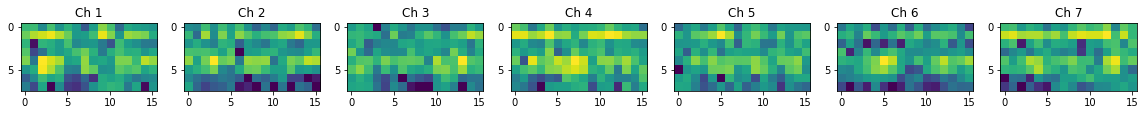

In [ ]:
show_sample(class_name = "P_x10_y9", sample = 280, crop_area = crop_area, size = size)

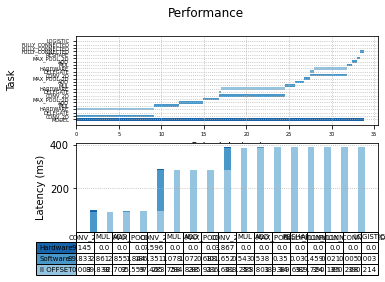

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1)

fig.suptitle('Performance')

#Python:
begin   = np.array([0.000, 0.002, 0.005, 0.032, 9.201, 12.065, 14.922, 16.765, 16.768, 16.959, 24.567, 25.646, 26.719, 27.413, 27.415, 27.976, 31.851, 32.396, 32.935, 33.287, 33.318, 33.778, 33.799, 33.806, ])
latency = np.array([33.810, 9.196, 0.033, 9.145, 2.862, 2.855, 1.842, 7.799, 0.213, 7.596, 1.077, 1.071, 0.692, 4.436, 0.571, 3.867, 0.543, 0.538, 0.350, 0.030, 0.458, 0.020, 0.005, 0.003, ])
event   = ["MODEL", "CONV_2D", "DELEGATE", "HARDWARE", "MUL", "ADD", "MAX_POOL_2D", "CONV_2D", "DELEGATE", "HARDWARE", "MUL", "ADD", "MAX_POOL_2D", "CONV_2D", "DELEGATE", "HARDWARE", "MUL", "ADD", "MAX_POOL_2D", "RESHAPE", "FULLY_CONNECTED", "FULLY_CONNECTED", "FULLY_CONNECTED", "LOGISTIC", ]
colors  = ["#1864ab", "#4a98c9", "#6faed4", "#94c4df", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#6faed4", "#94c4df", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#6faed4", "#94c4df", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", ]

data = [[0.003, 89.838, 92.702, 95.559, 97.405, 283.758, 284.838, 285.911, 286.601, 388.255, 388.801, 389.340, 389.692, 389.724, 390.185, 390.208, 390.214, ],
        [ 89.833, 2.861, 2.855, 1.844, 186.351, 1.078, 1.072, 0.688, 101.652, 0.543, 0.538, 0.350, 0.030, 0.459, 0.021, 0.005, 0.003, ],
        [ 9.145, 0.000, 0.000, 0.000, 7.596, 0.000, 0.000, 0.000, 3.867, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, ]]
columns = ("CONV_2D", "MUL", "ADD", "MAX_POOL_2D", "CONV_2D", "MUL", "ADD", "MAX_POOL_2D", "CONV_2D", "MUL", "ADD", "MAX_POOL_2D", "RESHAPE", "FULLY_CONNECTED", "FULLY_CONNECTED", "FULLY_CONNECTED", "LOGISTIC", )


ax1.barh(range(len(begin)),  latency, left=begin, color=colors)
ax1.grid(linestyle = ':')


plt.sca(ax1)
plt.yticks(range(len(begin)), event)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.tick_params(axis='both', which='minor', labelsize=1)

plt.xlabel("Schedule (ms)")
plt.ylabel("Task")

rows = ["Hardware", "Software", "II OFFSET"]

# Get some pastel shades for the colors
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax2.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(data[row])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

plt.sca(ax2)
# Add a table at the bottom of the axes
the_table = ax2.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom',
                      fontsize='xx-small')

the_table.auto_set_font_size(False)
the_table.set_fontsize(7)


# Adjust layout to make room for the table:

plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Latency (ms)")

plt.xticks([])
ax2.grid(linestyle = ':')


plt.show()